In [1]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn

#Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering

#Models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from wittgenstein import RIPPER
from sklearn.neural_network import MLPClassifier

#Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, learning_curve, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, \
    classification_report, plot_roc_curve

#visualize the decision tree obtained 
import pydotplus 
from IPython.display import Image

from imblearn.over_sampling import SMOTE

In [2]:
vendor_df_num = pd.read_csv('./task1-result_num_wo_out.csv', sep=',', index_col=[0,1])
vendor_df_cat = pd.read_csv('./task1-result_cat_wo_out.csv', sep=',', index_col=[0,1])

#Used for retrieving the outliers from task 1
vendor_df_num_w_out = pd.read_csv('./task1-result_num_w_out.csv', sep=',', index_col=[0,1])
vendor_df_cat_w_out = pd.read_csv('./task1-result_cat_w_out.csv', sep=',', index_col=[0,1])

df_ram = pd.read_csv('./ram.csv', sep=',', index_col=0)
df_geo = pd.read_csv('./geography.csv', sep=',', index_col=0)

## Categorical features discretisation

In [3]:
vendor_df_cat_discr = vendor_df_cat.copy()
vendor_df_cat_discr_w_out = vendor_df_cat_w_out.copy()

### TopBrand

In [4]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,CORSAIR,New Zeland,NZD,11
2,Adorama,CRUCIAL,United States of America,USD,4
3,Alternate,G.SKILL,France,EUR,3
4,Alternate Italia,G.SKILL,Italy,EUR,3
5,Alza,KINGSTON,United Kingdom,GBP,12


In [5]:
brand_names = sorted(df_ram["brand"].unique())
brand_map = dict(zip(brand_names, range(len(brand_names))))

vendor_df_cat_discr.loc[:, "TopBrand"] = vendor_df_cat_discr["TopBrand"].transform(lambda x, feat_map=brand_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopBrand"] = vendor_df_cat_discr_w_out["TopBrand"].transform(lambda x, feat_map=brand_map: feat_map[x])

### TopCountry

In [6]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,9,New Zeland,NZD,11
2,Adorama,10,United States of America,USD,4
3,Alternate,17,France,EUR,3
4,Alternate Italia,17,Italy,EUR,3
5,Alza,30,United Kingdom,GBP,12


In [7]:
country_names = sorted(df_geo["country"].unique())
country_map = dict(zip(country_names, range(len(country_names))))

vendor_df_cat_discr.loc[:, "TopCountry"] = vendor_df_cat_discr["TopCountry"].transform(lambda x, feat_map=country_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopCountry"] = \
        vendor_df_cat_discr_w_out["TopCountry"].transform(lambda x, feat_map=country_map: feat_map[x])

### TopCurrency

In [8]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,9,7,NZD,11
2,Adorama,10,10,USD,4
3,Alternate,17,3,EUR,3
4,Alternate Italia,17,6,EUR,3
5,Alza,30,9,GBP,12


In [9]:
currency_names = sorted(df_geo["currency"].unique())
currency_map = dict(zip(currency_names, range(len(currency_names))))

vendor_df_cat_discr.loc[:, "TopCurrency"] = vendor_df_cat_discr["TopCurrency"].transform(lambda x, feat_map=currency_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopCurrency"] = \
        vendor_df_cat_discr_w_out["TopCurrency"].transform(lambda x, feat_map=currency_map: feat_map[x])

### TopSalesMonth

In [10]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,9,7,4,11
2,Adorama,10,10,5,4
3,Alternate,17,3,2,3
4,Alternate Italia,17,6,2,3
5,Alza,30,9,3,12


Already expressed in numerical values, ready to be normalised.

### Merge all features in a single dataset

In [11]:
vendor_df = pd.concat([vendor_df_num, vendor_df_cat_discr], axis=1)
vendor_df_w_out = pd.concat([vendor_df_num_w_out, vendor_df_cat_discr_w_out], axis=1)

## Normalisation

In [12]:
vend_scaler = MinMaxScaler()
vend_scaler.fit(vendor_df.values)
vendor_norm = vend_scaler.transform(vendor_df.values)
vendor_df_norm = pd.DataFrame(vendor_norm, columns=vendor_df.columns, index=vendor_df.index)

## Define big-seller/small-seller label

In [13]:
vendor_df.head()

,,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,,,,,,,,,,,
1,1stWave Technologies,774,60,565.439098,132.989886,13.074935,4117.366865,25,5.361843,0.643988,0.643988,9,7,4,11
2,Adorama,3274,186,1761.990000,146.248003,14.628894,23940.798168,20,6.754711,0.000000,0.000000,10,10,5,4
3,Alternate,3047,203,860.154236,155.134195,11.530030,157564.631150,3,7.373634,1.679995,0.000000,17,3,2,3
4,Alternate Italia,407,101,774.077840,142.140184,10.034398,28925.527422,2,6.486558,0.898296,0.898296,17,6,2,3
5,Alza,12959,276,1188.115658,166.036705,13.514777,126568.803904,17,7.612859,1.165894,1.094659,30,9,3,12


What defines a seller as big?  
Let's start by taking a look at the labels in the results of the clustering task.

In [14]:
clust_labels = AgglomerativeClustering(n_clusters=2, linkage="average").fit(vendor_norm).labels_
clust_labels_df = vendor_df_norm.copy()
clust_labels_df.loc[:, "Label"] = -1

for i in range(len(clust_labels)):
    
    if clust_labels[i] == 0:
        clust_labels_df.iloc[i, -1] = "small-seller"
    else:
        clust_labels_df.iloc[i, -1] = "big-seller"

In [15]:
clust_labels_df.loc[clust_labels_df["Label"] == "small-seller"].max()

I                             1.0
Iu                            1.0
MaxValuePerOrder              1.0
AvgValuePerOrder              1.0
AvgMemoryPerOrder             1.0
IAvgMonthSales                1.0
TotMonthBusiness              1.0
Eram                          1.0
Egeo                          1.0
Ecur                          1.0
TopBrand                      0.5
TopCountry                    1.0
TopCurrency                   1.0
TopSalesMonth                 1.0
Label                small-seller
dtype: object

In [16]:
clust_labels_df.loc[clust_labels_df["Label"] == "big-seller"].min()

I                           0.0
Iu                          0.0
MaxValuePerOrder            0.0
AvgValuePerOrder       0.072133
AvgMemoryPerOrder      0.091182
IAvgMonthSales         0.000419
TotMonthBusiness            0.0
Eram                        0.0
Egeo                        0.0
Ecur                        0.0
TopBrand                    1.0
TopCountry                  1.0
TopCurrency                 1.0
TopSalesMonth          0.818182
Label                big-seller
dtype: object

We will take inspiration from the clustering results and define the **big-seller/small-seller** labels by using the **I/IAvgMonthSales** .  

Unfortunately, if we were to perfectly adhere to the clustering results, the number of samples in the **big-seller** label is too low to perform any meaningful predictive analysis.  
We will therefore expand the meaning of **big-seller**, currently dominated by the **I** feature (note the min and max of **I** for each label), to also include entries that have a relatively low **I** but a high **IAvgSalesMonth** value.

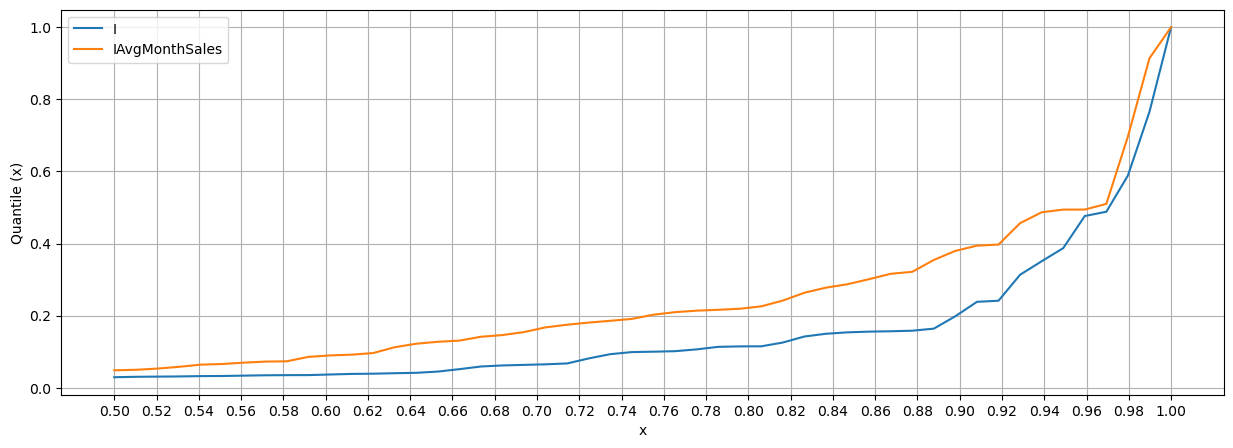

In [17]:
key_features = ["I", "IAvgMonthSales"]
pred_label_df = vendor_df_norm.copy()

pred_label_df[key_features].quantile(np.linspace(0.5, 1, 50)).plot(figsize=(15,5), grid=True)
plt.xlabel("x")
plt.ylabel("Quantile (x)")
plt.xticks(np.arange(0.5, 1.02, 0.02))
plt.show()

In [18]:
pred_label_df["Label"] = "small-seller"

pred_label_df.loc[pred_label_df["I"] >= pred_label_df["I"].quantile(0.80), "Label"] = "big-seller"
pred_label_df.loc[pred_label_df["IAvgMonthSales"] >= pred_label_df["IAvgMonthSales"].quantile(0.90), "Label"] = "big-seller"

pred_label_df.groupby("Label").size()

Label
big-seller      16
small-seller    59
dtype: int64

We decide to go with:
- big-seller: any entry having **I** >= quantile(0.8) or **IAvgMonthSales** >= quantile(0.8) of the whole dataset
- small-seller: everything else

We decided to go for this definition based on the above plot, in which the values of these features start to take off (forming a knee) around that value.  
This definition doubles the amount of data points that we have to work with when it comes to the **big-seller** label.

In [19]:
small_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "small-seller"]
small_seller_df_norm.describe()

,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.027195,0.112363,0.160053,0.264247,0.361157,0.068316,0.595339,0.518504,0.292167,0.259680,0.178370,0.576271,0.501695,0.451464
std,0.028808,0.096034,0.121216,0.222967,0.211379,0.085802,0.380786,0.205527,0.204815,0.218184,0.224417,0.404432,0.364593,0.351265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005920,0.036977,0.063853,0.122839,0.209956,0.012075,0.208333,0.416818,0.192710,0.000000,0.000000,0.050000,0.100000,0.181818
50%,0.018712,0.088424,0.124713,0.172221,0.320440,0.038242,0.666667,0.566039,0.328149,0.300021,0.023810,0.700000,0.600000,0.272727
75%,0.035073,0.165997,0.259288,0.347845,0.476771,0.080837,1.000000,0.672809,0.368002,0.394126,0.190476,0.900000,0.800000,0.818182
max,0.113253,0.543408,0.492266,1.000000,1.000000,0.368735,1.000000,0.899448,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
big_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "big-seller"]
big_seller_df_norm.describe()

,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.312479,0.408762,0.336851,0.248761,0.431251,0.397517,0.882812,0.782936,0.299745,0.303996,0.328869,0.562500,0.512500,0.477273
std,0.247203,0.257505,0.242397,0.120629,0.095910,0.251342,0.180161,0.117875,0.127232,0.160005,0.210499,0.359398,0.318067,0.308734
min,0.114889,0.165595,0.153306,0.127989,0.308643,0.129627,0.500000,0.644442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.154051,0.225683,0.164017,0.179757,0.362183,0.210666,0.864583,0.682351,0.264957,0.291278,0.190476,0.200000,0.200000,0.250000
50%,0.202028,0.303457,0.291883,0.211621,0.405553,0.357635,1.000000,0.759081,0.351979,0.385131,0.500000,0.700000,0.600000,0.545455
75%,0.390255,0.481310,0.324304,0.292474,0.503459,0.494118,1.000000,0.892422,0.386953,0.426001,0.500000,0.900000,0.800000,0.659091
max,1.000000,1.000000,1.000000,0.639707,0.607392,1.000000,1.000000,1.000000,0.390736,0.431248,0.500000,1.000000,1.000000,1.000000


## Feature correlations

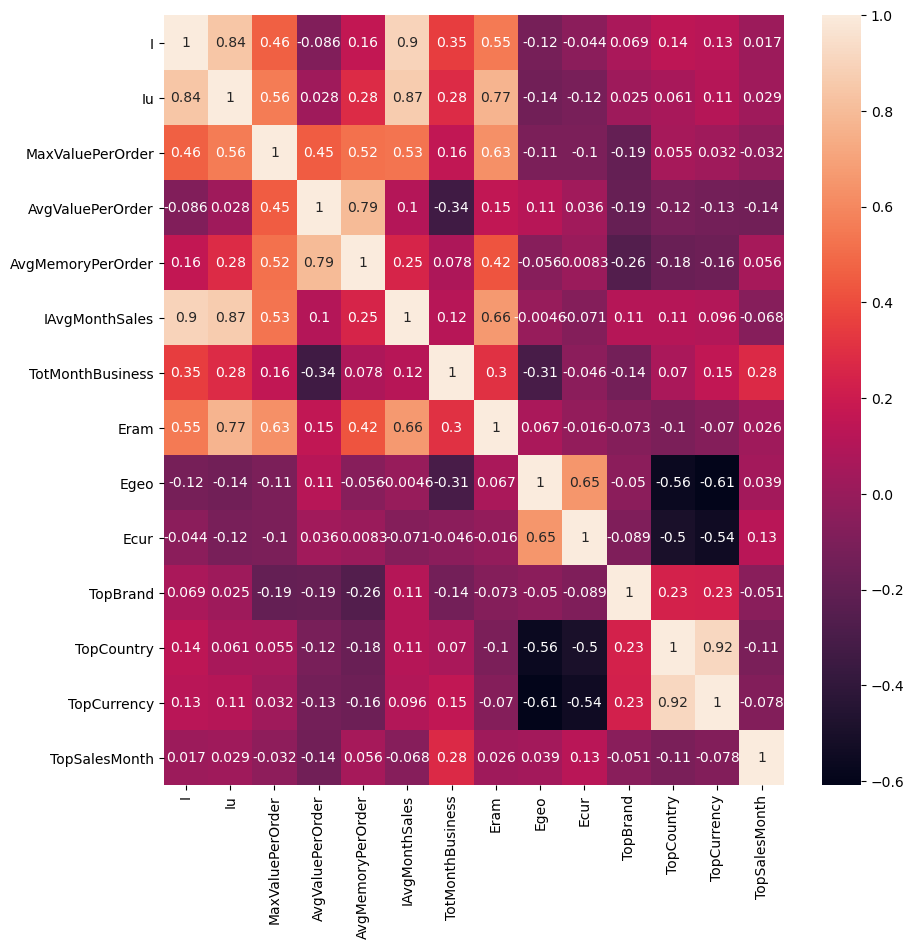

In [21]:
plt.figure(figsize=(10,10))
sn.heatmap(vendor_df.corr(), annot=True)
plt.show()

## Dataset preparation

### Add outliers  

In [22]:
outlier_df = vendor_df_w_out.loc[~vendor_df_w_out.index.isin(vendor_df.index)]
outlier_df

,,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,,,,,,,,,,,
32,geizhals_unknown,2020083,1733,10630.741494,164.006403,14.541547,5.343654e+06,62,10.512789,0.337642,0.000000,17,4,2,3
43,Mindfactory,248228,774,6044.234544,207.345263,19.361700,2.058756e+06,25,9.189418,0.334336,0.000000,17,4,2,1
68,pricespy_unknown,318591,1659,4465.589602,220.574502,20.171635,1.849291e+06,38,10.118133,0.441207,0.441207,9,9,3,3


We already know from our analysis that the outliers from Task 1 present extreme values in the **I/IAvgSalesMonth** features, therefore it seems only natural to include them as **big-sellers**.

In [23]:
vend_w_out_scaler = StandardScaler()
vend_w_out_norm = vend_w_out_scaler.fit_transform(vendor_df_w_out.values)
vend_w_out_df_norm = pd.DataFrame(vend_w_out_norm, columns=vendor_df_w_out.columns, index=vendor_df_w_out.index)

vend_w_out_df_norm.head()

,,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,,,,,,,,,,,
1,1stWave Technologies,-0.182784,-0.625345,-0.676333,-0.729306,-0.648874,-0.314942,0.709453,-0.683483,0.496859,0.779285,-0.925129,0.329216,0.863271,1.373472
2,Adorama,-0.171925,-0.245242,0.090633,-0.569198,-0.308858,-0.285252,0.222328,0.088941,-1.565545,-1.273951,-0.818855,1.107364,1.443747,-0.506016
3,Alternate,-0.172911,-0.193958,-0.487426,-0.461887,-0.986908,-0.085125,-1.433894,0.432169,3.814725,-1.273951,-0.074937,-0.708314,-0.297680,-0.774514
4,Alternate Italia,-0.184378,-0.501660,-0.542600,-0.618805,-1.314161,-0.277787,-1.531318,-0.059765,1.311293,1.590099,-0.074937,0.069834,-0.297680,-0.774514
5,Alza,-0.129857,0.026261,-0.277209,-0.330226,-0.552633,-0.131547,-0.069946,0.564833,2.168290,2.216167,1.306626,0.847981,0.282796,1.641970


This time we choose to use a StandardScaler instead of a MinMaxScaler given its better handling of outliers and because the focus of this task is not the direct interpretability of these values but the behaviour of each model.

In [24]:
vend_w_out_df_norm.loc[big_seller_df_norm.index, "Label"] = "big-seller"
vend_w_out_df_norm.loc[outlier_df.index, "Label"] = "big-seller"

vend_w_out_df_norm.loc[small_seller_df_norm.index, "Label"] = "small-seller"

### Removal of features used to define labels

In [25]:
pred_df = vend_w_out_df_norm.copy().drop(["I", "IAvgMonthSales", "Iu"], axis=1)
labels = pred_df.pop('Label')

We also tried removing the **Iu** feature given its high correlation with the features removed, however the results were very lackluster across the board probably pointing out that the other features are not correlated enough with the missing ones to correctly learn the labels or that there are not enough data points to retrieve them.  
The crucial assumption being that if a model is capable of generalising sufficiently it shouldn't have a problem dealing with data points 

### Train/test split

As suggested in the literature we use a 70-30 split for training/test set.

In [26]:
#Normalised data
train_set, test_set, train_label, test_label = train_test_split(pred_df, labels, stratify=labels, test_size=0.3, random_state=0)

print(f"Train set size (unbalanced): {len(train_set)}")
print(f"Test set size (unbalanced): {len(test_set)}")

Train set size (unbalanced): 54
Test set size (unbalanced): 24


### Class balancing  
Some of the functions provided by sklearn do not allow for a weighting of the classification scores based on the support of the class, therefore we need to prepare a balanced dataset.  
In order to avoid having the model overfit by simply memorising the repeated datapoints, we will therefore generate new data using SMOTE.

In [27]:
ros = SMOTE(random_state=0)

train_set_bal, train_label_bal = ros.fit_resample(train_set, train_label)

print(f"Train set size (balanced): {len(train_set_bal)}")

Train set size (balanced): 82


Note that it balancing has to take place after the train-test split, otherwise information will bleed out into the test set, making our results less reliable.

## Auxiliary functions

### Visualisation

In [28]:
def plot_learning_curve(estimator, title, X, y, ax=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    ax : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if ax is None:
        _, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title(title)
    if ylim is not None:
        ax[0].set_ylim(*ylim)
    ax[0].set_xlabel("Training examples")
    ax[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax[0].grid()
    ax[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax[0].legend(loc="best")

    # Plot n_samples vs fit_times
    ax[1].grid()
    ax[1].plot(train_sizes, fit_times_mean, 'o-')
    ax[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    ax[1].set_xlabel("Training examples")
    ax[1].set_ylabel("fit_times")
    ax[1].set_title("Scalability of the model")

    return plt

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                    test_pred, 
                    target_names=['big-seller', 'small-seller']))

## Decision trees

### Parameter search and fitting

We chose to set the min_samples_leaf value to 1, following a rule of thumb for small datasets and limit the number of features to the interval [2,3,4], since for each increase in the number of features considered a decision tree needs a significant amount of additional data to avoid overfitting.  
The lower limit of the interval is due to the correlations of the features, we know that no single feature has a strong enough correlation to explain the hidden behaviour.  

In [29]:
random_state_dt = 0

In order to make a more apple-to-apple comparison we will pick a random_state and use it across decision trees.  

The variance in the prediction results that can be seen by removing this variable is due to the tendency of decision trees to alter dramatically their structure for each perturbation of the training set.  
This is one of the reasons for the success of random forests compared to single decision trees.  

#### Unbalanced classes

In [30]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 5),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": range(2, 5),
              "criterion": ["gini", "entropy"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_unb = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_dt_unb.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_unb.cv_results_['mean_test_score'][0], 
      grid_search_dt_unb.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_unb = tree.DecisionTreeClassifier(**grid_search_dt_unb.best_params_)
dt_unb.fit(train_set, train_label)

test_pred_dt_unb = dt_unb.predict(test_set)
test_pred_proba_dt_unb = dt_unb.predict_proba(test_set)

Best settings parameters  {'criterion': 'gini', 'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 9, 'random_state': 0}
Setting's accuracy score mean and std  0.8163636363636364 0.09797958971132713


#### Balanced classes

In [31]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 5),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": range(2, 5),
              "criterion": ["gini", "entropy"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_bal = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_dt_bal.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_bal.cv_results_['mean_test_score'][0], 
      grid_search_dt_bal.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_bal = tree.DecisionTreeClassifier(**grid_search_dt_bal.best_params_)
dt_bal.fit(train_set_bal, train_label_bal)

test_pred_dt_bal = dt_bal.predict(test_set)
test_pred_proba_dt_bal = dt_bal.predict_proba(test_set)

Best settings parameters  {'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}
Setting's accuracy score mean and std  0.8801470588235294 0.0827197712377955


#### Balanced classes with class_weight

In [32]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 5),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": range(2, 5),
              "criterion": ["gini", "entropy"],
              "class_weight": ["balanced"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_wei = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_dt_wei.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_wei.cv_results_['mean_test_score'][0], 
      grid_search_dt_wei.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_wei = tree.DecisionTreeClassifier(**grid_search_dt_wei.best_params_)
dt_wei.fit(train_set, train_label)

test_pred_dt_wei = dt_wei.predict(test_set)
test_pred_proba_dt_wei = dt_wei.predict_proba(test_set)

Best settings parameters  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 0}
Setting's accuracy score mean and std  0.8181818181818181 0.15212000482437738


### Evaluation

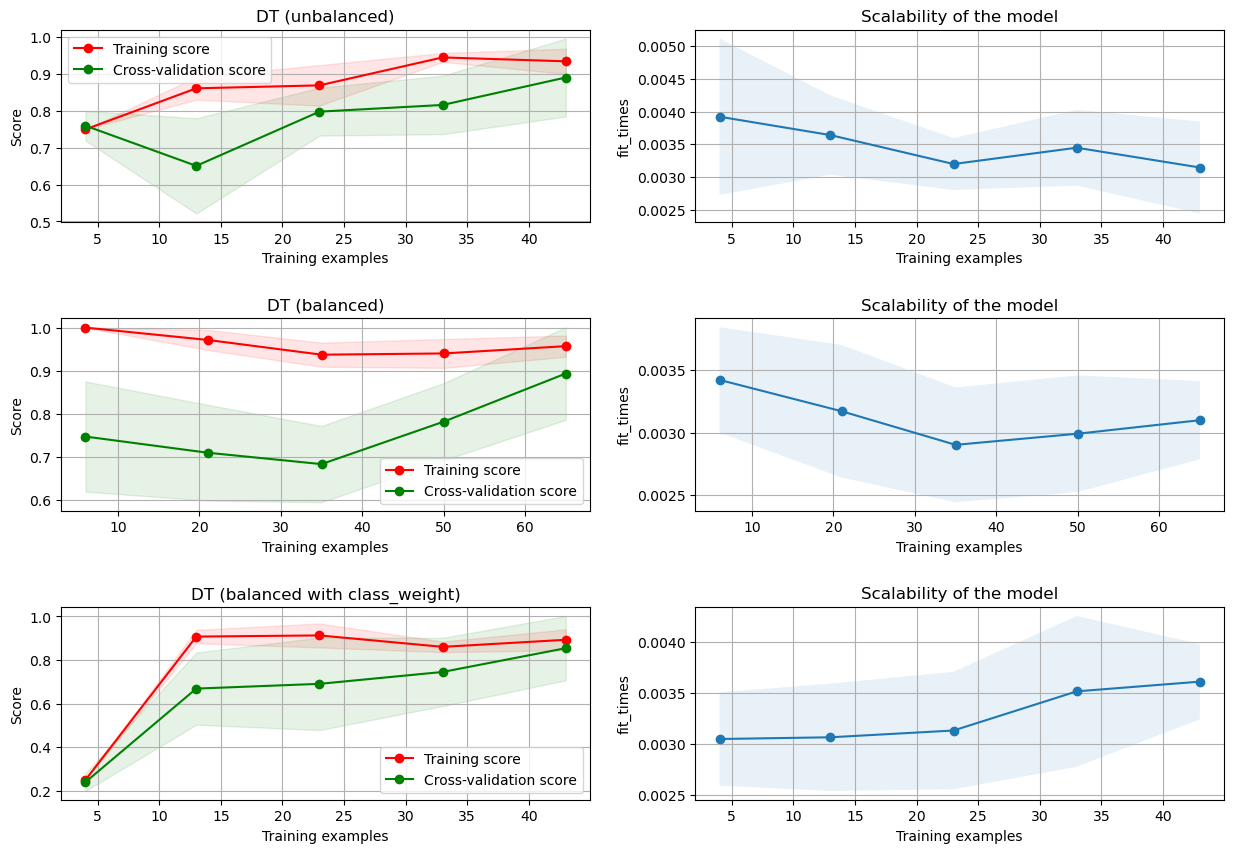

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plot_learning_curve(dt_unb, "DT (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(dt_bal, "DT (balanced)", train_set_bal, train_label_bal, ax=axes[1])
plot_learning_curve(dt_wei, "DT (balanced with class_weight)", train_set,train_label, ax=axes[2])

plt.show()

The learning curve suggests, through the upward trend of the cv score, that the model would benefit from more data points, as we pointed out above.

DT (unbalanced)


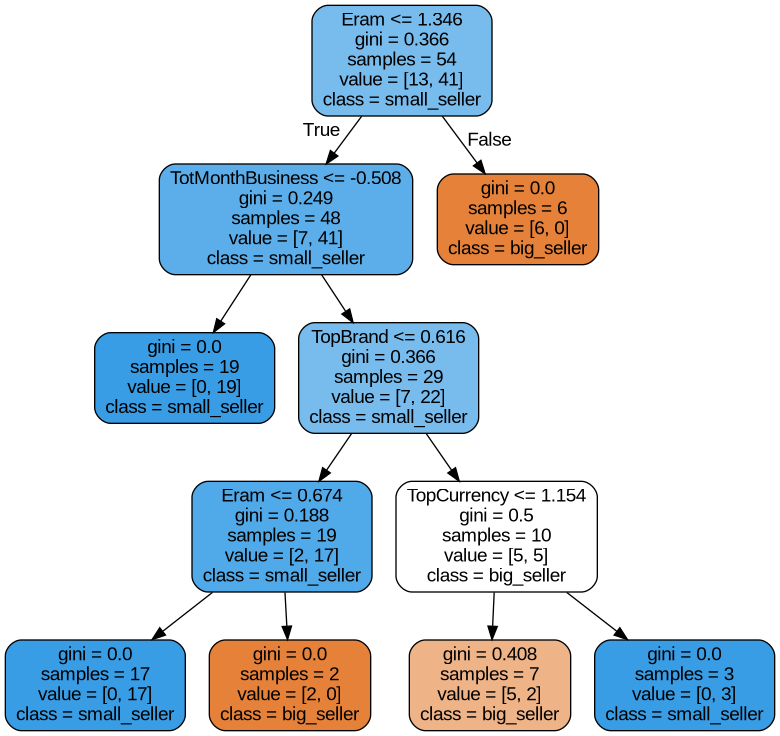

In [34]:
print("DT (unbalanced)")
dot_data = tree.export_graphviz(dt_unb, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced)


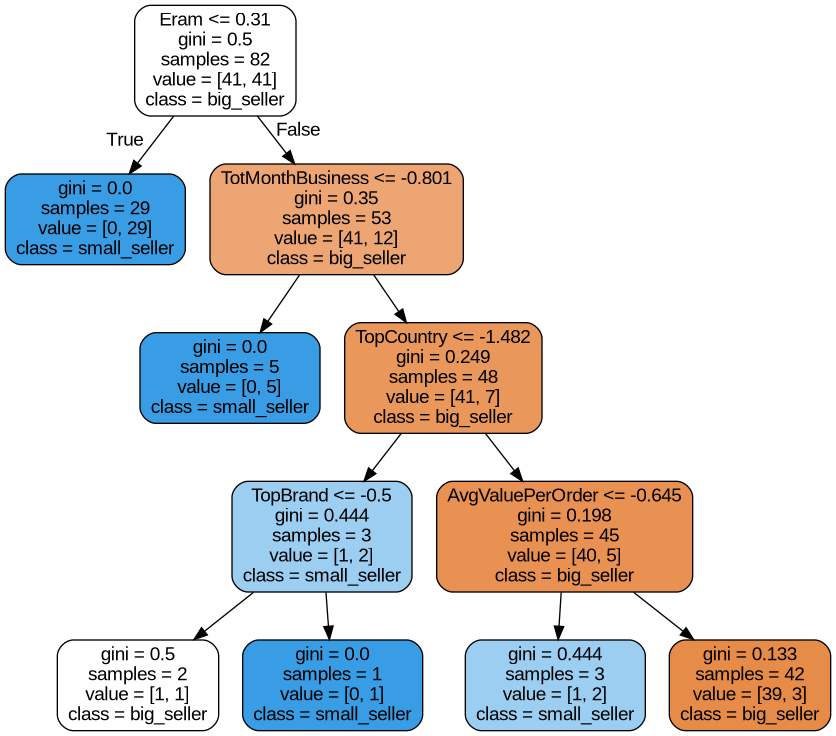

In [35]:
print("DT (balanced)")
dot_data = tree.export_graphviz(dt_bal, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced with class_weight)


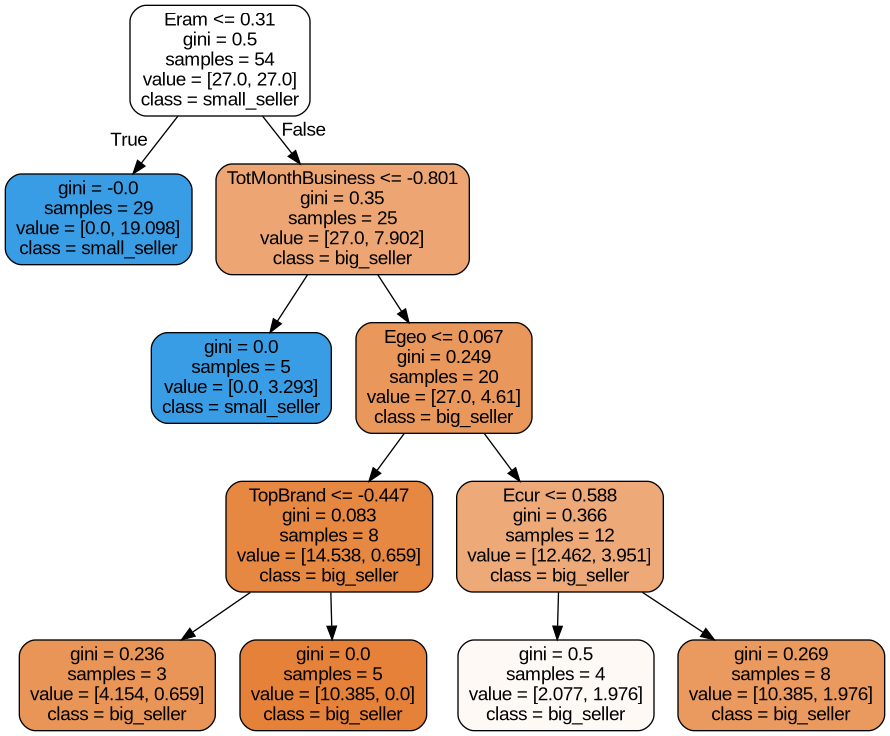

In [36]:
print("DT (balanced with class_weight)")
dot_data = tree.export_graphviz(dt_wei, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [37]:
print("DT (unbalanced)")
report_scores(test_label, test_pred_dt_unb)
print("\n")
print("DT (balanced)")
report_scores(test_label, test_pred_dt_bal)
print("\n")
print("DT (balanced with class_weight)")
report_scores(test_label, test_pred_dt_wei)

DT (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.86      1.00      0.92         6
small-seller       1.00      0.94      0.97        18

    accuracy                           0.96        24
   macro avg       0.93      0.97      0.95        24
weighted avg       0.96      0.96      0.96        24



DT (balanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



DT (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.50      0.83      0.62         6
small-seller       0.93      0.72      0.81        18

    accuracy                           0.75        24
   macro avg       0.71      0.78      0.72        24
weighted

Both the metrics results and size of the decision tree seem to point to a case of overfitting in the first two decision trees, let's try to limit their complexity through filtering the nodes using ccp_alpha coefficients.

### Post-pruning  
Of the first two decision trees.

In [38]:
def ccp_alpha_pruning(dt, dt_params, dataset, labels, title=None):
    
    if title:
        print(title)
        
    path = dt.cost_complexity_pruning_path(dataset, labels)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    fig, ax = plt.subplots(3, 1, figsize=(10,10))

    ax[0].plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("Effective alpha")
    ax[0].set_ylabel("Total impurity of leaves")
    ax[0].set_title("Total Impurity vs effective alpha for training set")

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(**dt_params, ccp_alpha=ccp_alpha)
        clf.fit(dataset, labels)
        clfs.append(clf)

    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
          clfs[-1].tree_.node_count, ccp_alphas[-1]))


    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    ax[1].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("number of nodes")
    ax[1].set_title("Number of nodes vs alpha")
    ax[2].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
    ax[2].set_xlabel("alpha")
    ax[2].set_ylabel("depth of tree")
    ax[2].set_title("Depth vs alpha")
    fig.tight_layout()
    
    return ccp_alphas

DT (unbalanced)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.1441186556927298


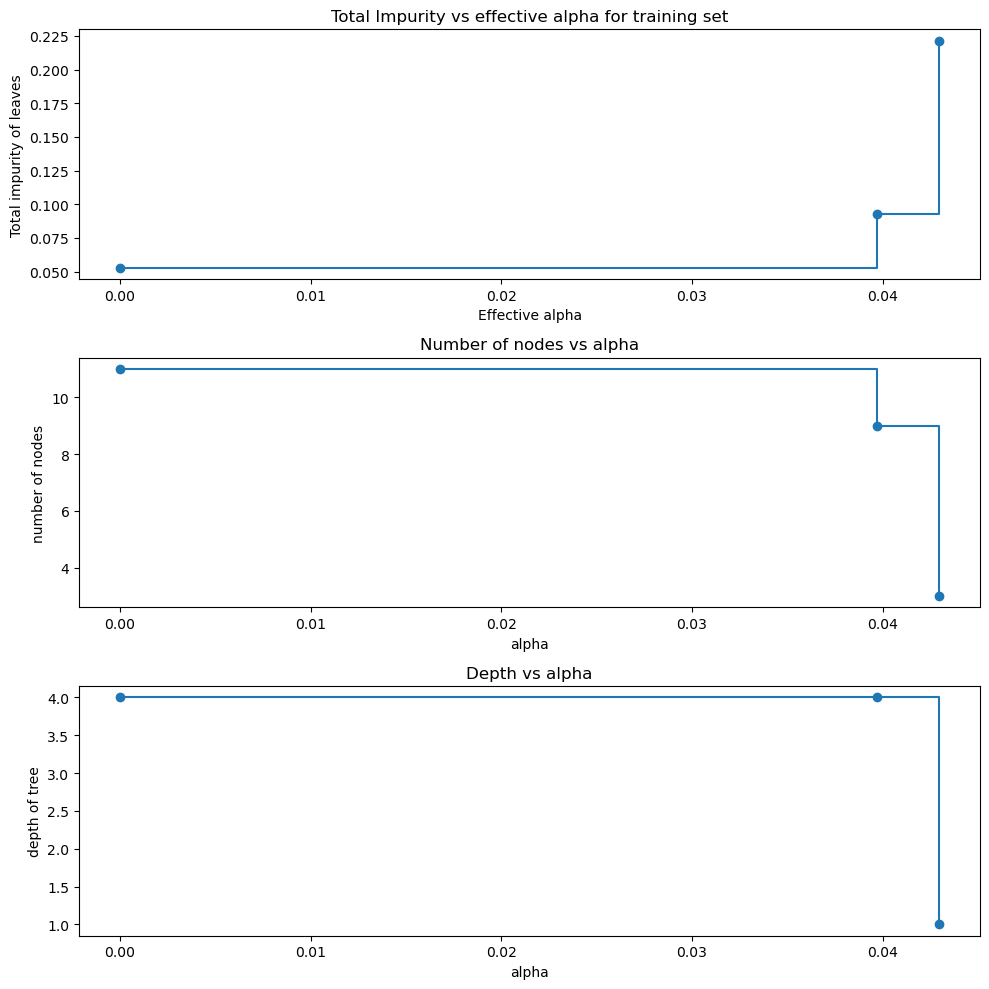

In [39]:
ccp_alphas_unb = ccp_alpha_pruning(dt_unb, grid_search_dt_unb.best_params_, train_set, train_label, "DT (unbalanced)")

DT (balanced)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.2735849056603774


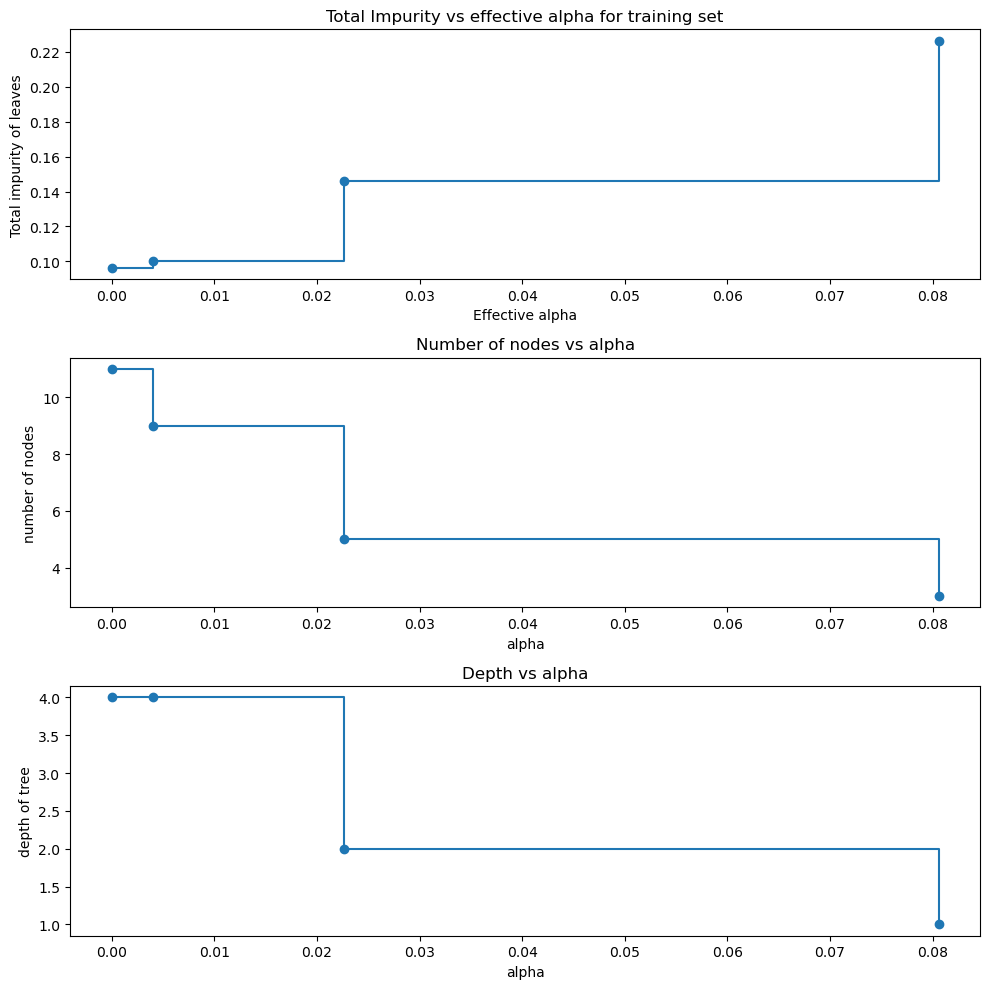

In [40]:
ccp_alphas_bal = ccp_alpha_pruning(dt_bal, grid_search_dt_bal.best_params_, train_set_bal, train_label_bal, "DT (balanced)")

DT (balanced ith class_weight)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.2735849056603772


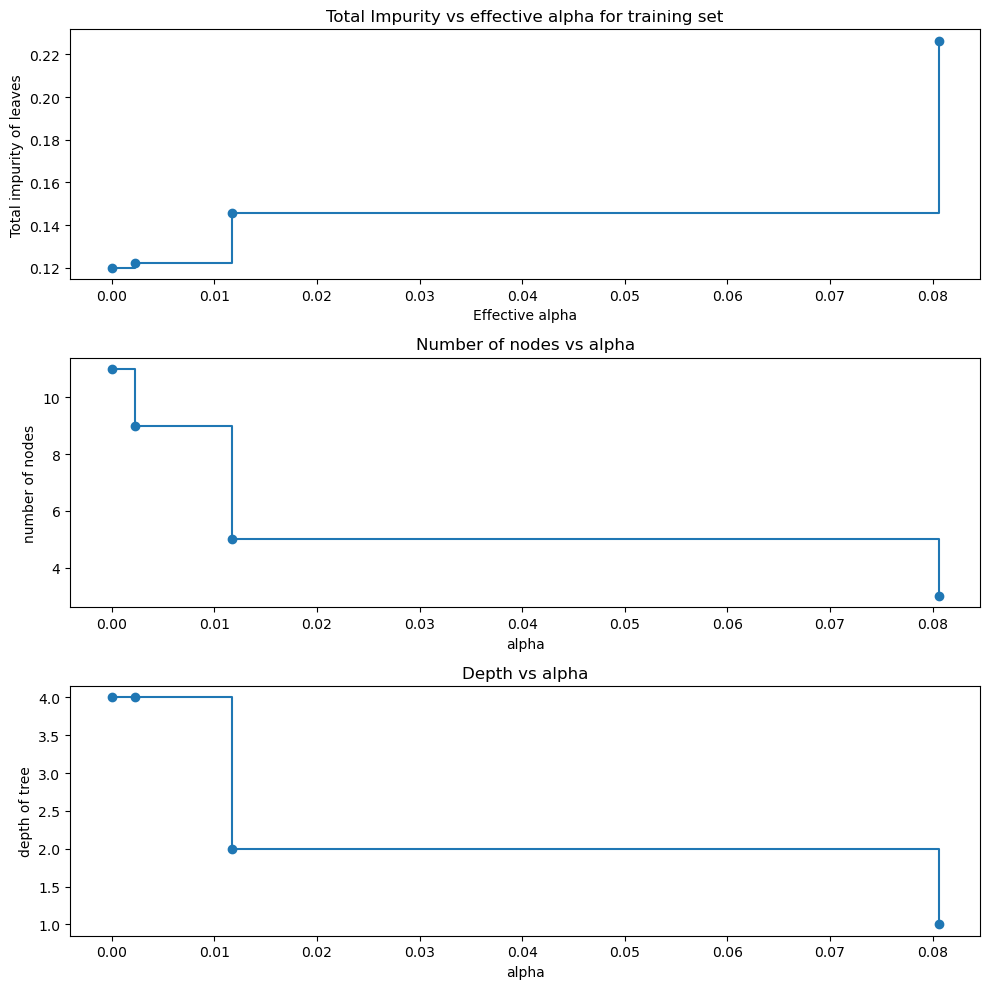

In [41]:
ccp_alphas_wei = ccp_alpha_pruning(dt_wei, grid_search_dt_wei.best_params_, train_set, train_label, "DT (balanced ith class_weight)")

We will ignore the cutoff points that reduce the trees to a single level/feature since they wouldn't have the capability to learn enough.

In [42]:
dt_unb_post = tree.DecisionTreeClassifier(**grid_search_dt_unb.best_params_, ccp_alpha=ccp_alphas_unb[-2])
dt_unb_post.fit(train_set, train_label)

test_pred_dt_unb_post = dt_unb_post.predict(test_set)
test_pred_proba_dt_unb_post = dt_unb_post.predict_proba(test_set)


dt_bal_post = tree.DecisionTreeClassifier(**grid_search_dt_bal.best_params_, ccp_alpha=ccp_alphas_bal[-2])
dt_bal_post.fit(train_set_bal, train_label_bal)

test_pred_dt_bal_post = dt_bal_post.predict(test_set)
test_pred_proba_dt_bal_post = dt_bal_post.predict_proba(test_set)


dt_wei_post = tree.DecisionTreeClassifier(**grid_search_dt_wei.best_params_, ccp_alpha=ccp_alphas_wei[-2])
dt_wei_post.fit(train_set, train_label)

test_pred_dt_wei_post = dt_wei_post.predict(test_set)
test_pred_proba_dt_wei_post = dt_wei_post.predict_proba(test_set)

DT (unbalanced, post-pruned)


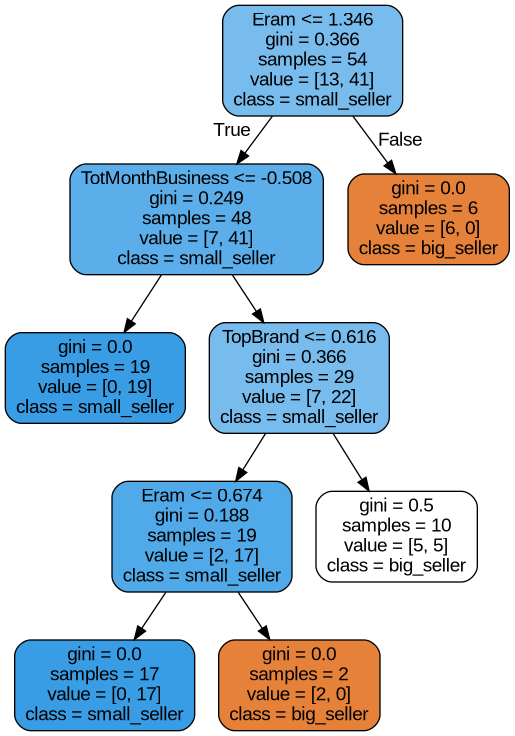

In [43]:
print("DT (unbalanced, post-pruned)")
dot_data = tree.export_graphviz(dt_unb_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

The tree cannot be further reduced.

DT (balanced, post-pruned)


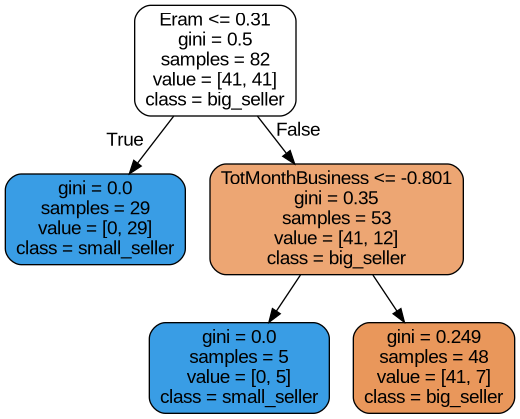

In [44]:
print("DT (balanced, post-pruned)")
dot_data = tree.export_graphviz(dt_bal_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced with class_weight, post-pruned)


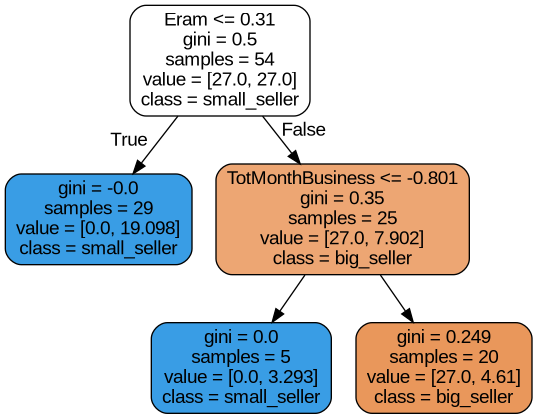

In [45]:
print("DT (balanced with class_weight, post-pruned)")
dot_data = tree.export_graphviz(dt_wei_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [46]:
print("DT (unbalanced)")
report_scores(test_label, test_pred_dt_unb_post)
print("\n")
print("DT (balanced)")
report_scores(test_label, test_pred_dt_bal_post)
print("\n")
print("DT (balanced with class_weight)")
report_scores(test_label, test_pred_dt_wei_post)

DT (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.75      1.00      0.86         6
small-seller       1.00      0.89      0.94        18

    accuracy                           0.92        24
   macro avg       0.88      0.94      0.90        24
weighted avg       0.94      0.92      0.92        24



DT (balanced)
              precision    recall  f1-score   support

  big-seller       0.50      0.83      0.62         6
small-seller       0.93      0.72      0.81        18

    accuracy                           0.75        24
   macro avg       0.71      0.78      0.72        24
weighted avg       0.82      0.75      0.77        24



DT (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.50      0.83      0.62         6
small-seller       0.93      0.72      0.81        18

    accuracy                           0.75        24
   macro avg       0.71      0.78      0.72        24
weighted

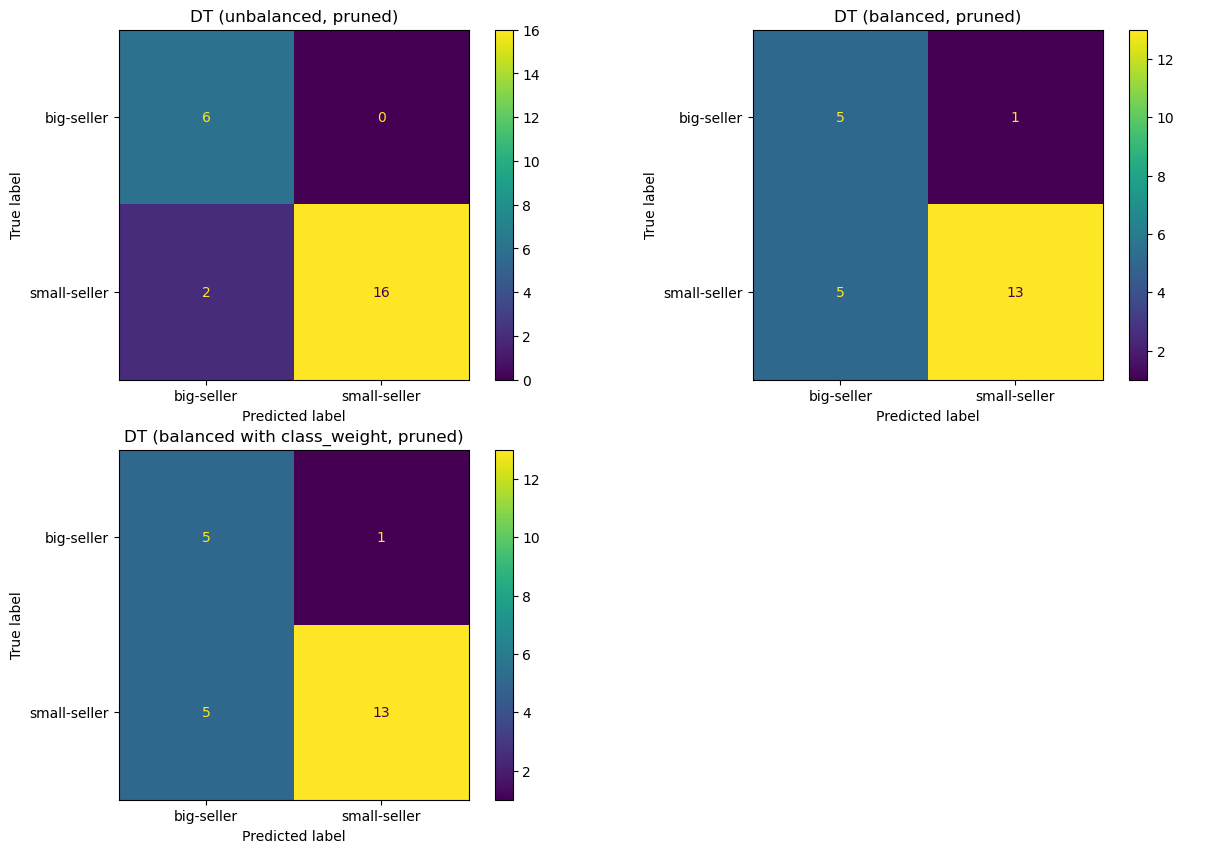

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0][0].set_title("DT (unbalanced, pruned)")
plot_confusion_matrix(dt_unb_post, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("DT (balanced, pruned)")
plot_confusion_matrix(dt_bal_post, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("DT (balanced with class_weight, pruned)")
plot_confusion_matrix(dt_wei_post, test_set, test_label, ax=axes[1][0])
axes[1][1].axis('off')
plt.show() 

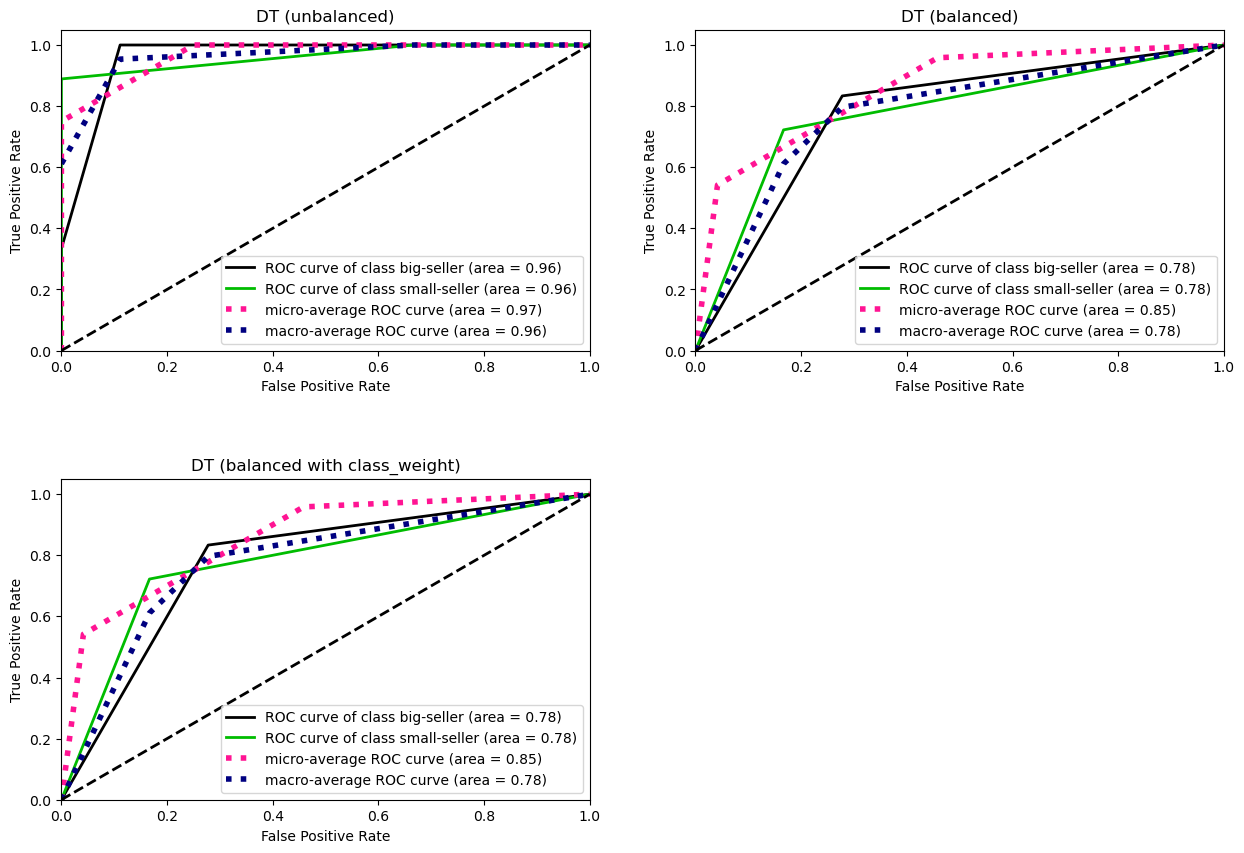

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_unb_post, title="DT (unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_bal_post, title="DT (balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_wei_post, title="DT (balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

### Conclusions
The metrics point to the model trained to the tree trained on the unbalanced dataset as the best one.  
This is due to its greater depth and number of features used to distinguish the datapoints.  
The results obtained from the balanced dataset and the tree with a "balanced" class_weight parameter are identical.

## Naives Bayes classifier (GaussianNB)

### Fitting

#### Unbalanced classes

In [49]:
gnb_unb = GaussianNB()
gnb_unb.fit(train_set, train_label)

test_pred_gnb_unb = gnb_unb.predict(test_set)
test_pred_proba_gnb_unb = gnb_unb.predict_proba(test_set)

#### Balanced classes

In [50]:
gnb_bal = GaussianNB()
gnb_bal.fit(train_set_bal, train_label_bal)

test_pred_gnb_bal = gnb_bal.predict(test_set)
test_pred_proba_gnb_bal = gnb_bal.predict_proba(test_set)

### Evaluation

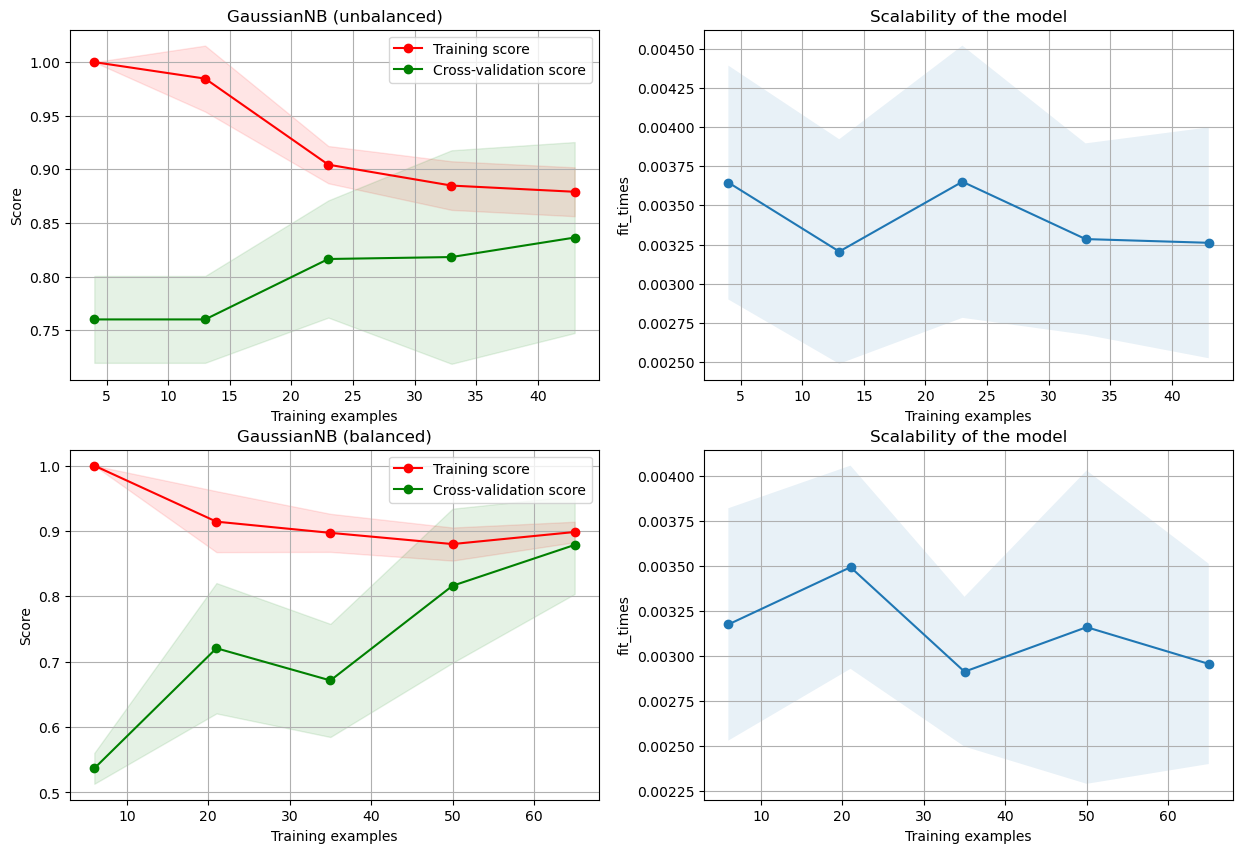

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_learning_curve(gnb_unb, "GaussianNB (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(gnb_bal, "GaussianNB (balanced)", train_set_bal, train_label_bal, ax=axes[1])

plt.show()

In [52]:
print("GaussianNB (unbalanced)")
report_scores(test_label, test_pred_gnb_unb)
print("\n")
print("GaussianNB (balanced)")
report_scores(test_label, test_pred_gnb_bal)

GaussianNB (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



GaussianNB (balanced)
              precision    recall  f1-score   support

  big-seller       0.67      1.00      0.80         6
small-seller       1.00      0.83      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.92      0.85        24
weighted avg       0.92      0.88      0.88        24



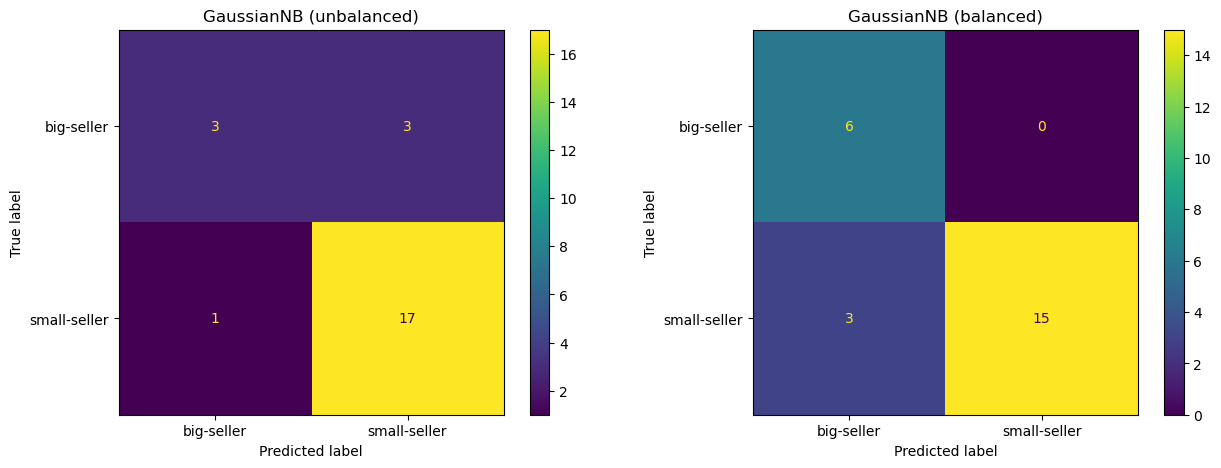

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("GaussianNB (unbalanced)")
plot_confusion_matrix(gnb_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("GaussianNB (balanced)")
plot_confusion_matrix(gnb_bal, test_set, test_label, ax=axes[1])
plt.show() 

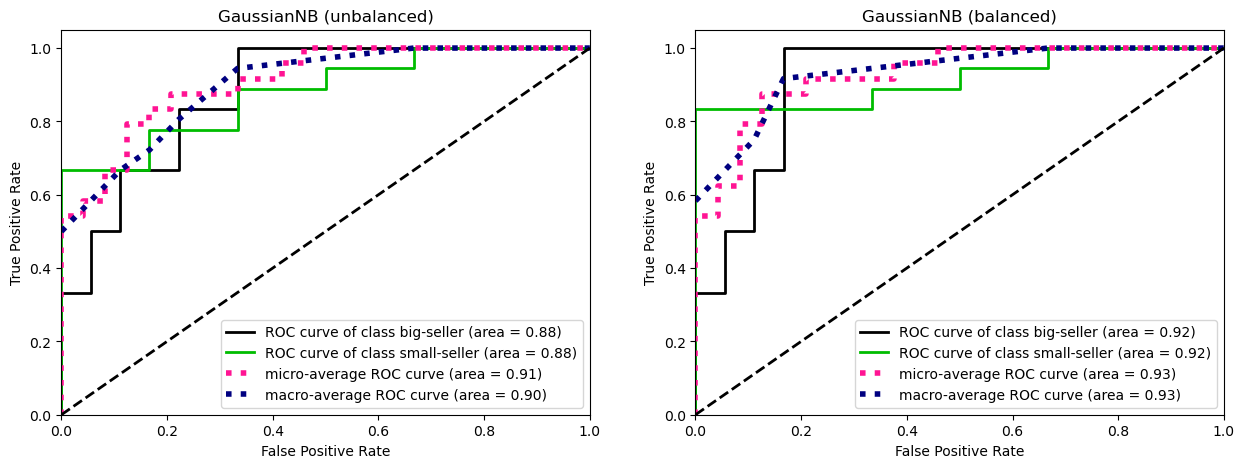

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_gnb_unb, title="GaussianNB (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_gnb_bal, title="GaussianNB (balanced)", ax=axes[1])
plt.show()

### Conclusions
The balanced dataset performed better overall, it showed a slightly lower precision for the big-seller label compared to the unbalanced one.  
However it has a recall of 1, meaning that all of the big sellers are detected as such.

## Random forest

In [55]:
random_state_rf = 0

### Unbalanced

In [56]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 5), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_unb = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_unb.cv_results_['mean_test_score'][0], 
      grid_search_rf_unb.cv_results_['std_test_score'][0])


rf_unb = RandomForestClassifier(**grid_search_rf_unb.best_params_) 
rf_unb = rf_unb.fit(train_set, train_label)

test_pred_rf_unb = rf_unb.predict(test_set)
test_pred_proba_rf_unb = rf_unb.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
Setting's accuracy score mean and std  0.8181818181818181 0.11499191491521377


### Balanced

In [57]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 5), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_bal = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_bal.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_bal.cv_results_['mean_test_score'][0], 
      grid_search_rf_bal.cv_results_['std_test_score'][0])


rf_bal = RandomForestClassifier(**grid_search_rf_bal.best_params_) 
rf_bal = rf_bal.fit(train_set_bal, train_label_bal)

test_pred_rf_bal = rf_bal.predict(test_set)
test_pred_proba_rf_bal = rf_bal.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 35, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 2, 'criterion': 'gini', 'bootstrap': True}
Setting's accuracy score mean and std  0.8527272727272728 0.04240692287160216


### Balanced with class_weight

In [58]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 5), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True], 
              "class_weight": ["balanced"],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_wei = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_wei.cv_results_['mean_test_score'][0], 
      grid_search_rf_wei.cv_results_['std_test_score'][0])


rf_wei = RandomForestClassifier(**grid_search_rf_wei.best_params_) 
rf_wei = rf_wei.fit(train_set, train_label)

test_pred_rf_wei = rf_wei.predict(test_set)
test_pred_proba_rf_wei = rf_wei.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 4, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Setting's accuracy score mean and std  0.78 0.10701046523317935


### Evaluation

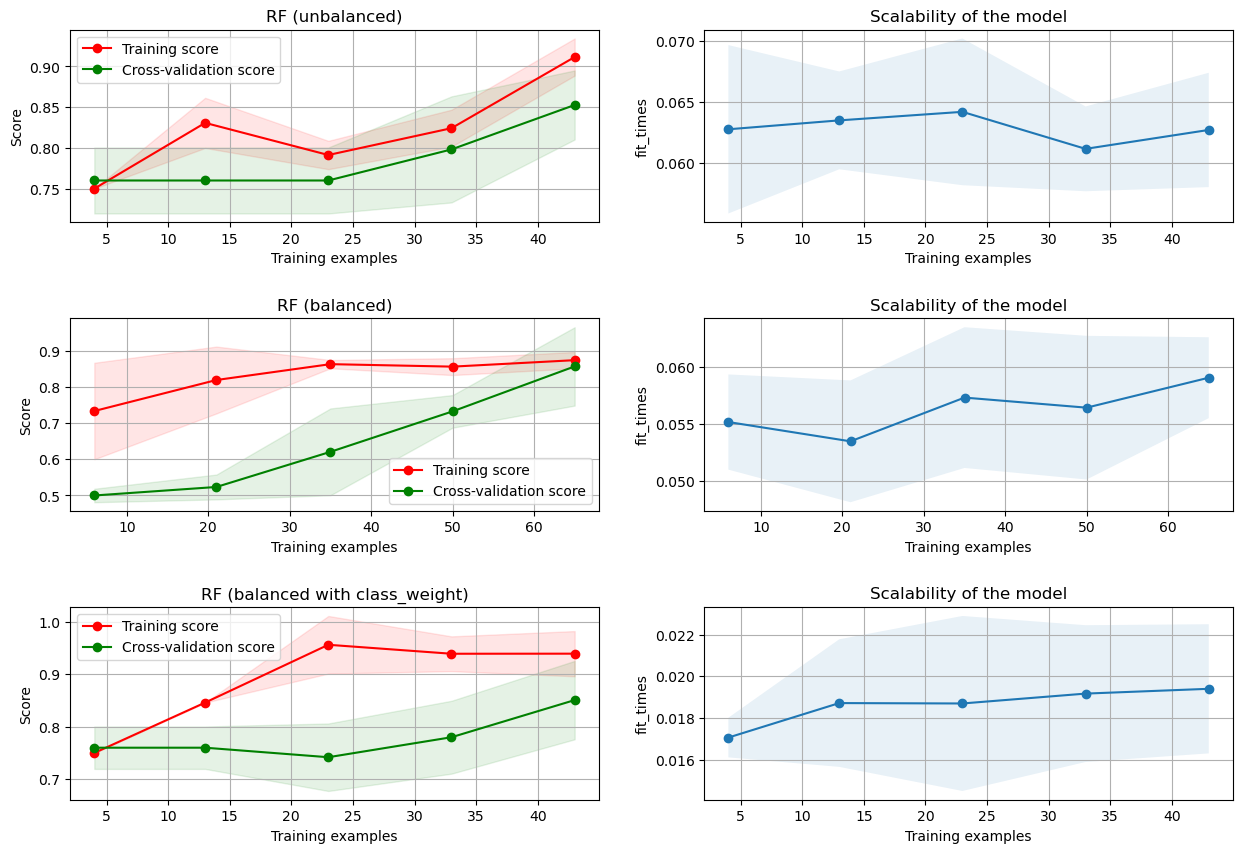

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plot_learning_curve(rf_unb, "RF (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(rf_bal, "RF (balanced)", train_set_bal, train_label_bal, ax=axes[1])
plot_learning_curve(rf_wei, "RF (balanced with class_weight)", train_set, train_label, ax=axes[2])

plt.show()

In [60]:
print("RF (unbalanced)")
report_scores(test_label, test_pred_rf_unb)
print("\n")
print("RF (balanced)")
report_scores(test_label, test_pred_rf_bal)
print("\n")
print("RF (balanced with class_weight)")
report_scores(test_label, test_pred_rf_wei)

RF (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.67      0.33      0.44         6
small-seller       0.81      0.94      0.87        18

    accuracy                           0.79        24
   macro avg       0.74      0.64      0.66        24
weighted avg       0.77      0.79      0.76        24



RF (balanced)
              precision    recall  f1-score   support

  big-seller       0.56      0.83      0.67         6
small-seller       0.93      0.78      0.85        18

    accuracy                           0.79        24
   macro avg       0.74      0.81      0.76        24
weighted avg       0.84      0.79      0.80        24



RF (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.38      0.50      0.43         6
small-seller       0.81      0.72      0.76        18

    accuracy                           0.67        24
   macro avg       0.59      0.61      0.60        24
weighted

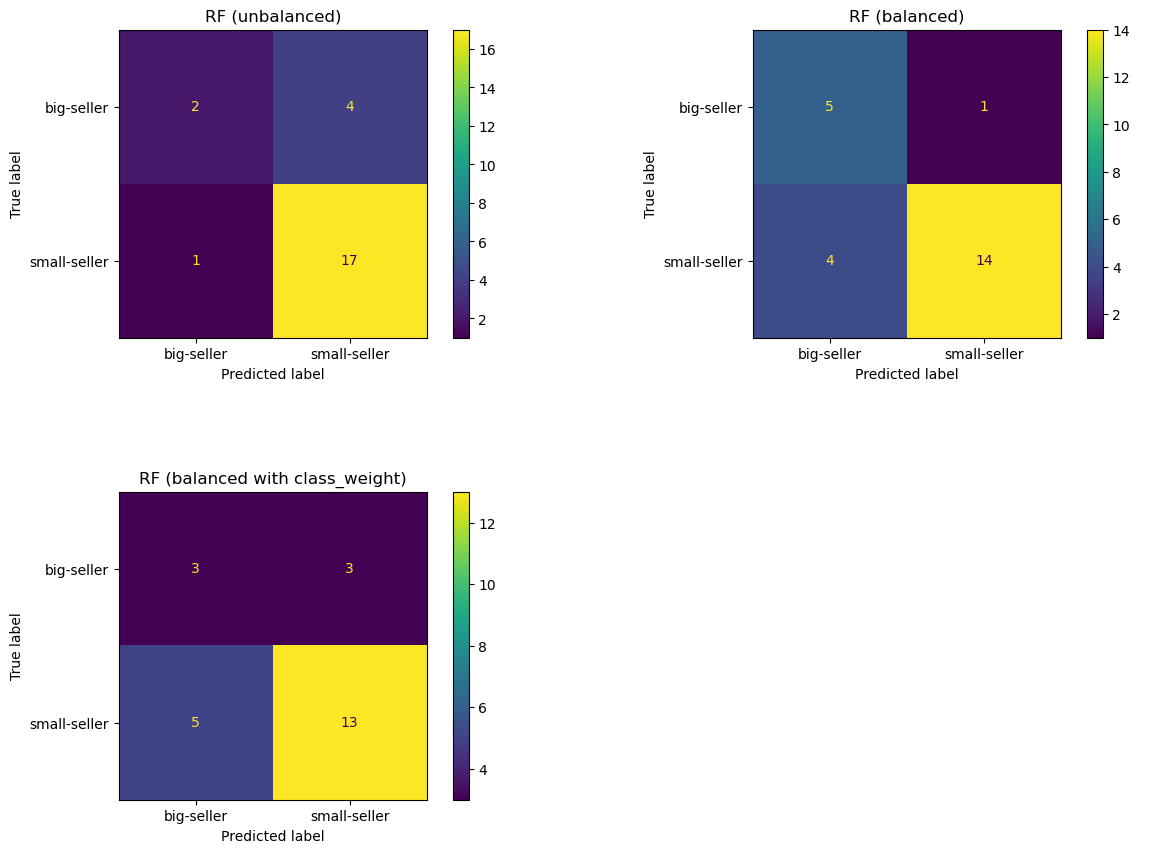

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("RF (unbalanced)")
plot_confusion_matrix(rf_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("RF (balanced)")
plot_confusion_matrix(rf_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("RF (balanced with class_weight)")
plot_confusion_matrix(rf_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

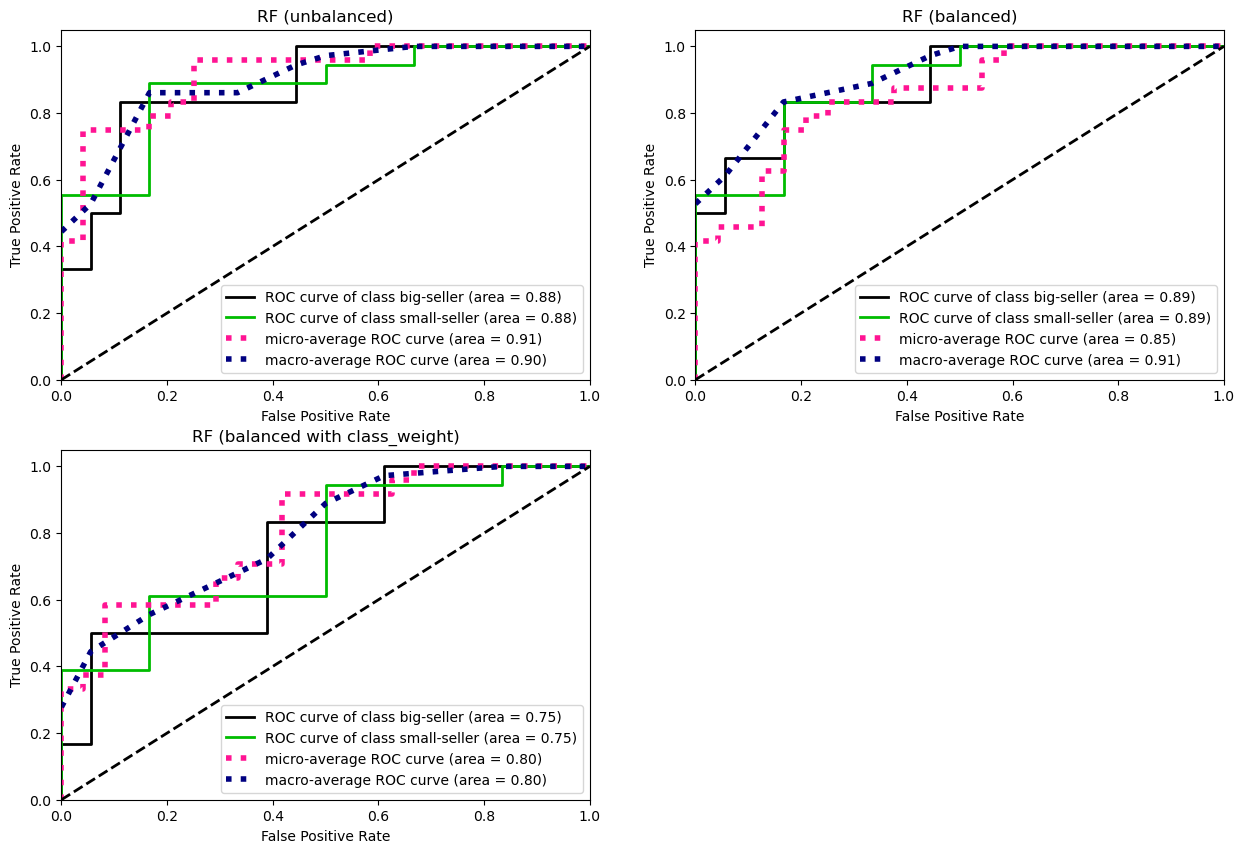

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_unb, title="RF (unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_bal, title="RF (balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_wei, title="RF (balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

### Conclusions
The model trained using class_weight offers better results.

## K-Nearest Neighbour
For the number of neighbours to query we use the sqrt(number of features) heuristic.

### Parameter search and fitting

#### Unbalanced classes

In [63]:
#define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [int(np.ceil(np.sqrt(pred_df.shape[1])))],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define the grid search
grid_search_knn_unb = RandomizedSearchCV(clf, param_distributions=param_dist_knn,
                            n_jobs=-1,
                            n_iter=12,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_knn_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_knn_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn_unb.cv_results_['mean_test_score'][0], 
      grid_search_knn_unb.cv_results_['std_test_score'][0])


knn_unb = KNeighborsClassifier(**grid_search_knn_unb.best_params_).fit(train_set, train_label)

test_pred_knn_unb = knn_unb.predict(test_set)
test_pred_proba_knn_unb = knn_unb.predict_proba(test_set)

Best settings parameters  {'weights': 'uniform', 'n_neighbors': 4, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Setting's accuracy score mean and std  0.7618181818181818 0.10670109637179064


#### Balanced classes

In [64]:
#define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [int(np.ceil(np.sqrt(pred_df.shape[1])))],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define search
grid_search_knn_bal = RandomizedSearchCV(clf, param_distributions=param_dist_knn,
                            n_jobs=-1,
                            n_iter=12,
                            scoring=make_scorer(accuracy_score))
#run the search
grid_search_knn_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_knn_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn_bal.cv_results_['mean_test_score'][0], 
      grid_search_knn_bal.cv_results_['std_test_score'][0])

#Actual model fitting
knn_bal = KNeighborsClassifier(**grid_search_knn_bal.best_params_).fit(train_set_bal, train_label_bal)

test_pred_knn_bal = knn_bal.predict(test_set)
test_pred_proba_knn_bal = knn_bal.predict_proba(test_set)

Best settings parameters  {'weights': 'uniform', 'n_neighbors': 4, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Setting's accuracy score mean and std  0.7470588235294118 0.165226985530224


### Evaluation

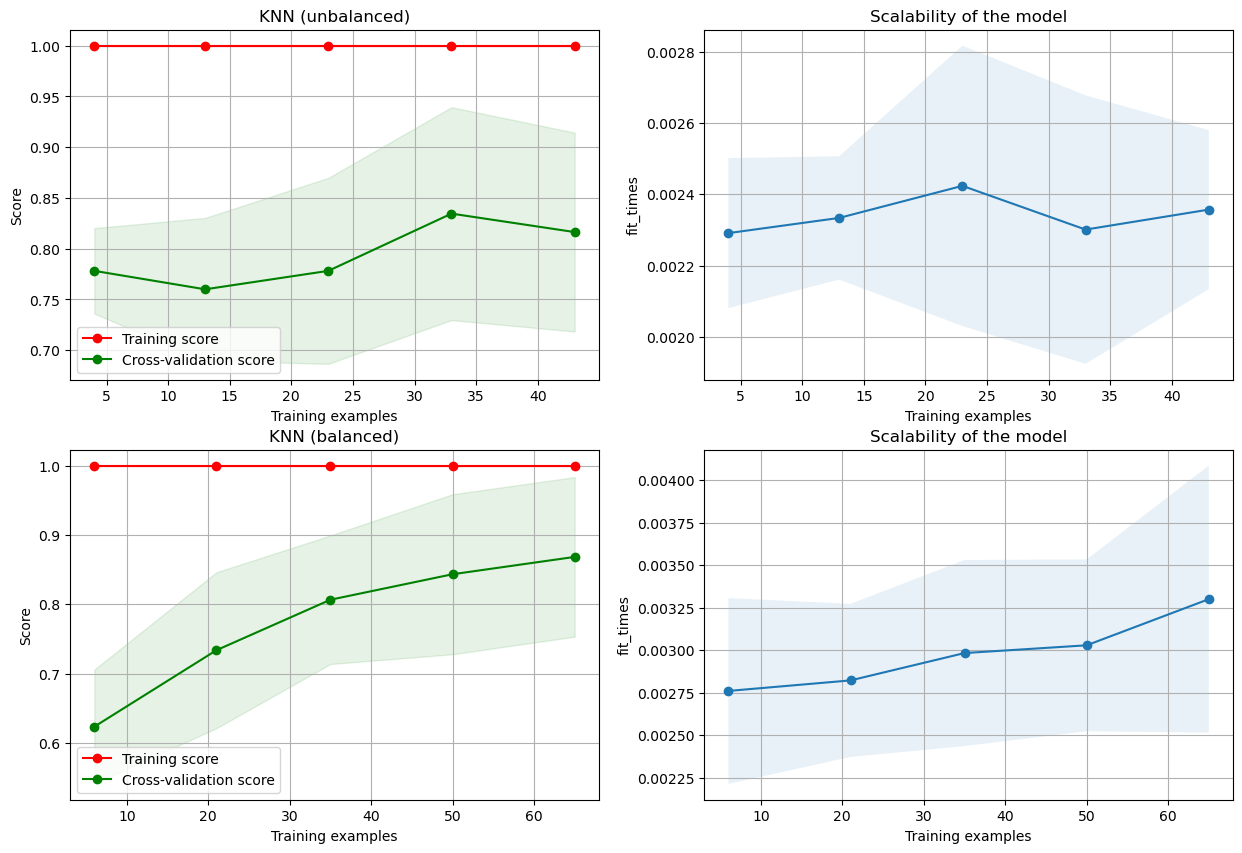

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_learning_curve(knn_unb, "KNN (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(knn_bal, "KNN (balanced)", train_set_bal, train_label_bal, ax=axes[1])

plt.show()

In [68]:
print("KNN (unbalanced)")
report_scores(test_label,test_pred_knn_unb)
print("\n")
print("KNN (balanced)")
report_scores(test_label,test_pred_knn_bal)

KNN (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.62      0.83      0.71         6
small-seller       0.94      0.83      0.88        18

    accuracy                           0.83        24
   macro avg       0.78      0.83      0.80        24
weighted avg       0.86      0.83      0.84        24



KNN (balanced)
              precision    recall  f1-score   support

  big-seller       0.46      1.00      0.63         6
small-seller       1.00      0.61      0.76        18

    accuracy                           0.71        24
   macro avg       0.73      0.81      0.70        24
weighted avg       0.87      0.71      0.73        24



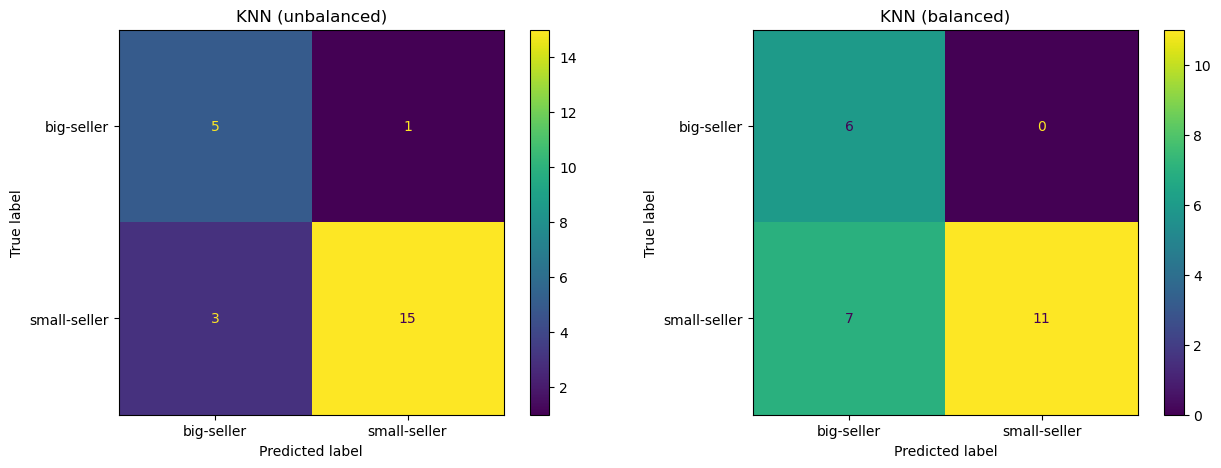

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("KNN (unbalanced)")
plot_confusion_matrix(knn_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("KNN (balanced)")
plot_confusion_matrix(knn_bal, test_set, test_label, ax=axes[1])
plt.show() 

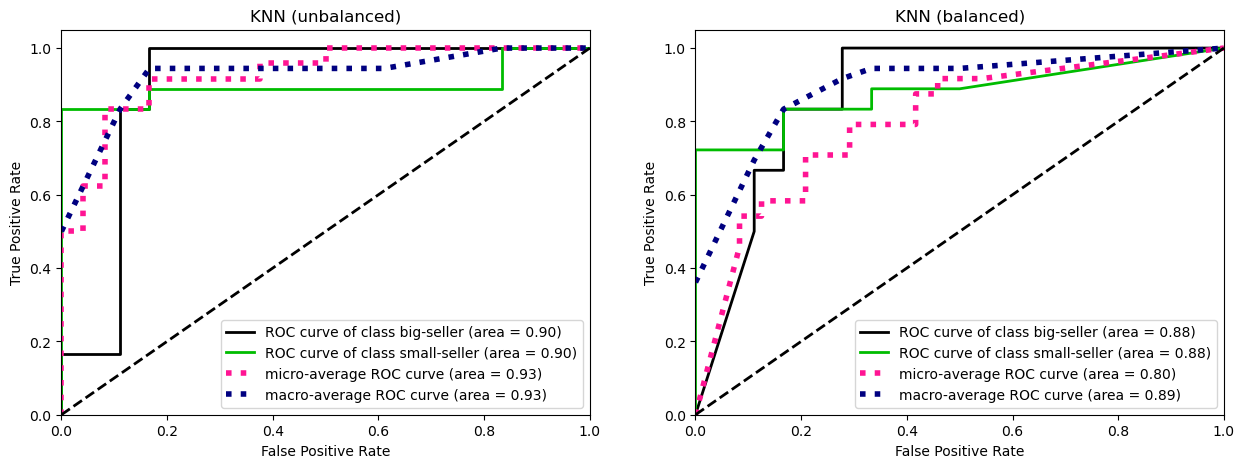

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_knn_unb, title="KNN (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_knn_bal, title="KNN (balanced)", ax=axes[1])
plt.show()

### Conclusions
We can see that with KNN having a balanced number of classes has a mixed impact on the results, depending on the usecase one model can be preferred over the other (ie if we care about identifying with certainty that a vendor is small we can use the second model)

## SVM

### Linear

#### Unbalanced

In [71]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_unb = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_lin_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_unb.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_unb.cv_results_['std_test_score'][0])


svm_lin_unb = SVC(**grid_search_svm_lin_unb.best_params_)
svm_lin_unb.fit(train_set, train_label)

test_pred_proba_svm_lin_unb = svm_lin_unb.predict_proba(test_set)
test_pred_svm_lin_unb = svm_lin_unb.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'C': 852.8543243243244}
Setting's accuracy score mean and std  0.909090909090909 0.08131156281817416


#### Balanced

In [72]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_bal = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_svm_lin_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_bal.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_bal.cv_results_['std_test_score'][0])


svm_lin_bal = SVC(**grid_search_svm_lin_bal.best_params_)
svm_lin_bal.fit(train_set_bal, train_label_bal)

test_pred_proba_svm_lin_bal = svm_lin_bal.predict_proba(test_set)
test_pred_svm_lin_bal = svm_lin_bal.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'C': 768.7710810810811}
Setting's accuracy score mean and std  0.9522058823529411 0.04424002634262155


#### Balanced with class_weight

In [73]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000), 
    "class_weight": ["balanced"]
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_wei = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_lin_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_wei.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_wei.cv_results_['std_test_score'][0])


svm_lin_wei = SVC(**grid_search_svm_lin_wei.best_params_)
svm_lin_wei.fit(train_set, train_label)

test_pred_proba_svm_lin_wei = svm_lin_wei.predict_proba(test_set)
test_pred_svm_lin_wei = svm_lin_wei.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 697.7007207207208}
Setting's accuracy score mean and std  0.909090909090909 0.08131156281817416


#### Evaluation

In [74]:
print("SVM (Linear, unbalanced)")
report_scores(test_label, test_pred_svm_lin_unb)
print("\n")
print("SVM (Linear, balanced)")
report_scores(test_label, test_pred_svm_lin_bal)
print("\n")
print("SVM (Linear, balanced with class_weight)")
report_scores(test_label, test_pred_svm_lin_wei)

SVM (Linear, unbalanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



SVM (Linear, balanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



SVM (Linear, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86  

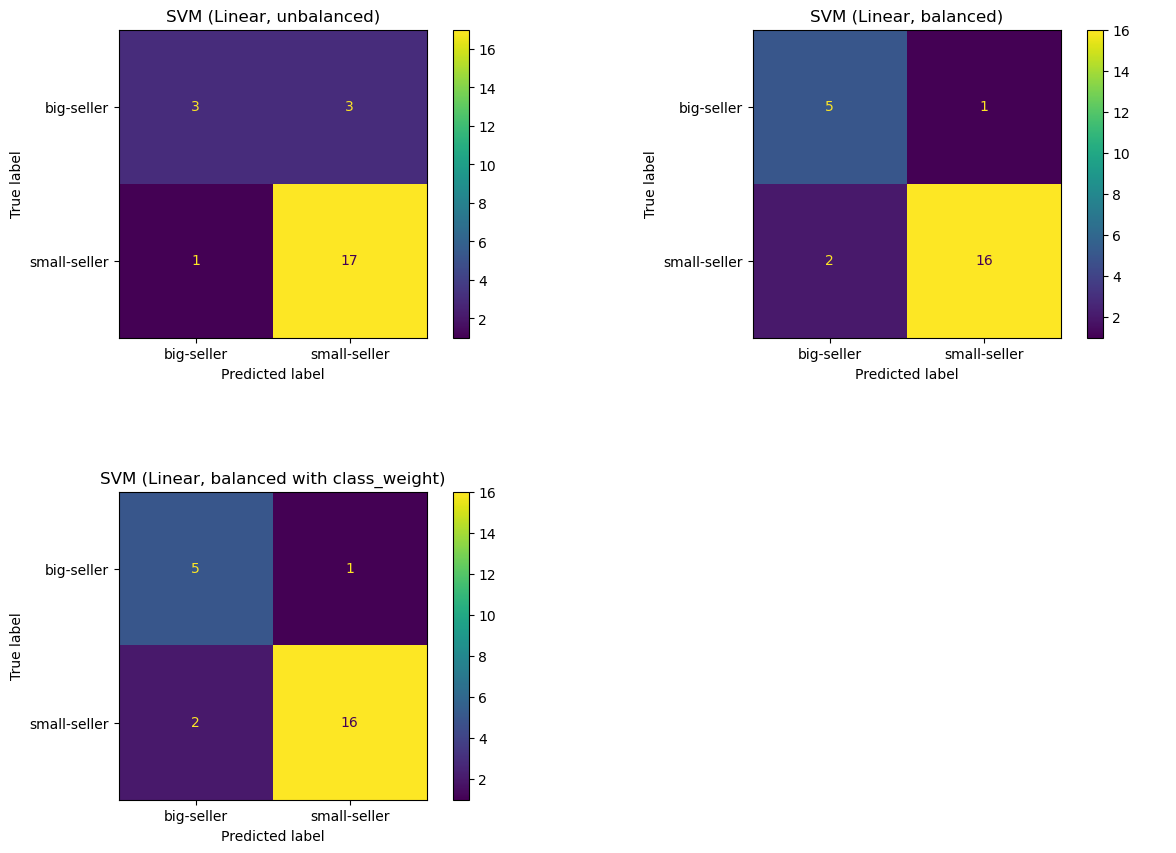

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("SVM (Linear, unbalanced)")
plot_confusion_matrix(svm_lin_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("SVM (Linear, balanced)")
plot_confusion_matrix(svm_lin_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("SVM (Linear, balanced with class_weight)")
plot_confusion_matrix(svm_lin_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

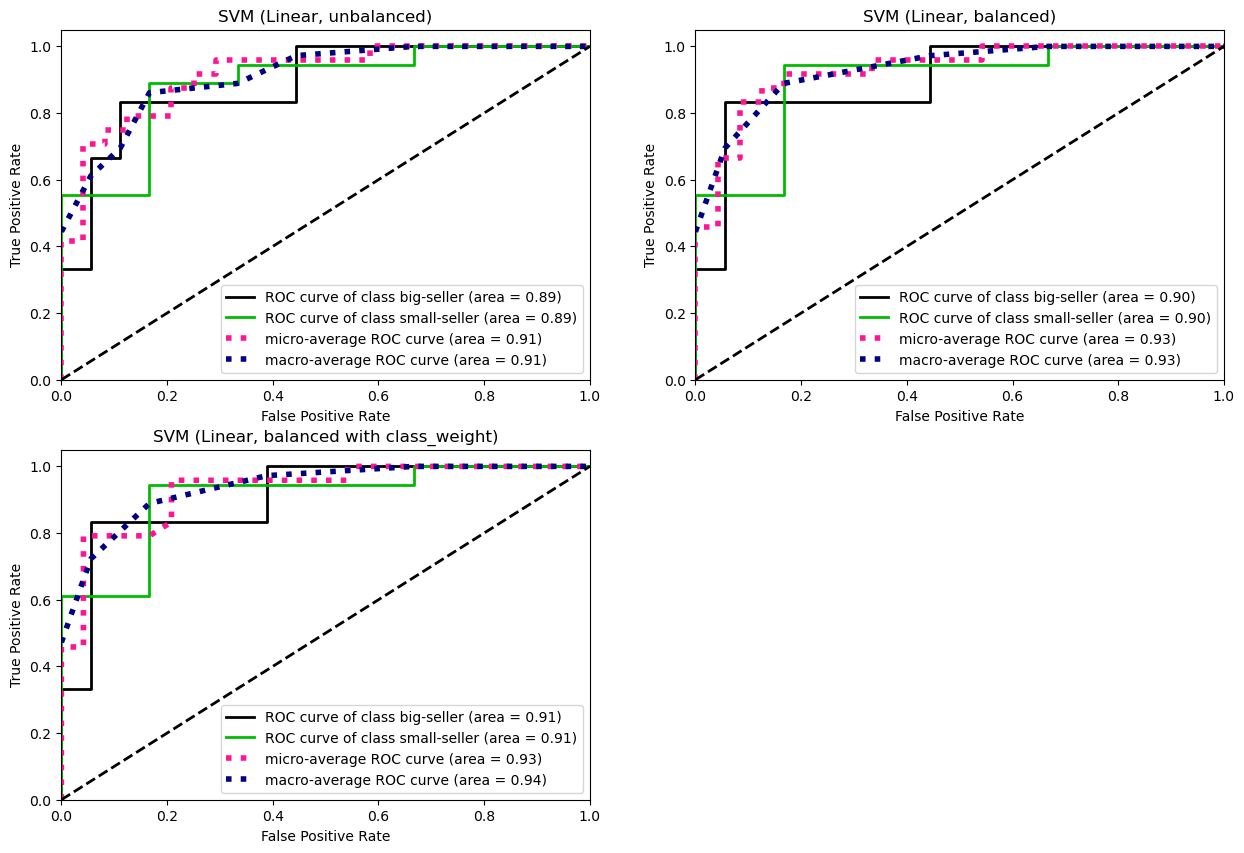

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_unb, title="SVM (Linear, unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_bal, title="SVM (Linear, balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_wei, title="SVM (Linear, balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

#### Conclusions
The results of the models trained on balanced datasets are better across the board.

### RBF

#### Unbalanced

In [77]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_unb = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_rbf_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_unb.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_unb.cv_results_['std_test_score'][0])


svm_rbf_unb = SVC(**grid_search_svm_rbf_unb.best_params_)
svm_rbf_unb.fit(train_set, train_label)

test_pred_proba_svm_rbf_unb = svm_rbf_unb.predict_proba(test_set)
test_pred_svm_rbf_unb = svm_rbf_unb.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'C': 195.20324324324326}
Setting's accuracy score mean and std  0.8345454545454546 0.10482571131199689


#### Balanced

In [78]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_bal = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_svm_rbf_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_bal.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_bal.cv_results_['std_test_score'][0])


svm_rbf_bal = SVC(**grid_search_svm_rbf_bal.best_params_)
svm_rbf_bal.fit(train_set_bal, train_label_bal)

test_pred_proba_svm_rbf_bal = svm_rbf_bal.predict_proba(test_set)
test_pred_svm_rbf_bal = svm_rbf_bal.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'C': 554.5590090090091}
Setting's accuracy score mean and std  0.9286764705882353 0.06848900601291188


#### Balanced with class_weight

In [79]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000), 
    "class_weight": ["balanced"]
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_wei = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_rbf_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_wei.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_wei.cv_results_['std_test_score'][0])


svm_rbf_wei = SVC(**grid_search_svm_rbf_wei.best_params_)
svm_rbf_wei.fit(train_set, train_label)

test_pred_proba_svm_rbf_wei = svm_rbf_wei.predict_proba(test_set)
test_pred_svm_rbf_wei = svm_rbf_wei.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 835.8374774774776}
Setting's accuracy score mean and std  0.8345454545454546 0.10482571131199689


In [80]:
print("SVM (RBF, unbalanced)")
report_scores(test_label, test_pred_svm_rbf_unb)
print("\n")
print("SVM (RBF, balanced)")
report_scores(test_label, test_pred_svm_rbf_bal)
print("\n")
print("SVM (RBF, balanced with class_weight)")
report_scores(test_label, test_pred_svm_rbf_wei)

SVM (RBF, unbalanced)
              precision    recall  f1-score   support

  big-seller       0.67      0.67      0.67         6
small-seller       0.89      0.89      0.89        18

    accuracy                           0.83        24
   macro avg       0.78      0.78      0.78        24
weighted avg       0.83      0.83      0.83        24



SVM (RBF, balanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



SVM (RBF, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.60      0.50      0.55         6
small-seller       0.84      0.89      0.86        18

    accuracy                           0.79        24
   macro avg       0.72      0.69      0.71 

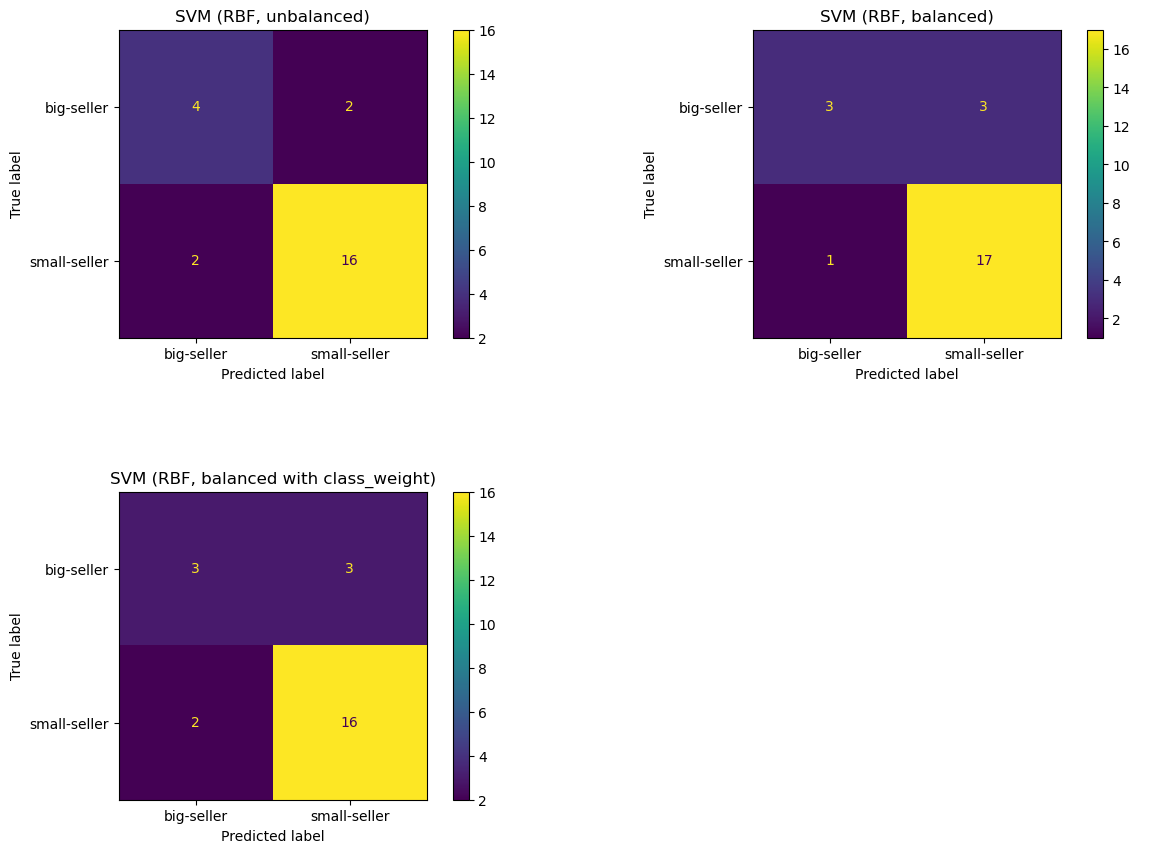

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("SVM (RBF, unbalanced)")
plot_confusion_matrix(svm_rbf_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("SVM (RBF, balanced)")
plot_confusion_matrix(svm_rbf_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("SVM (RBF, balanced with class_weight)")
plot_confusion_matrix(svm_rbf_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

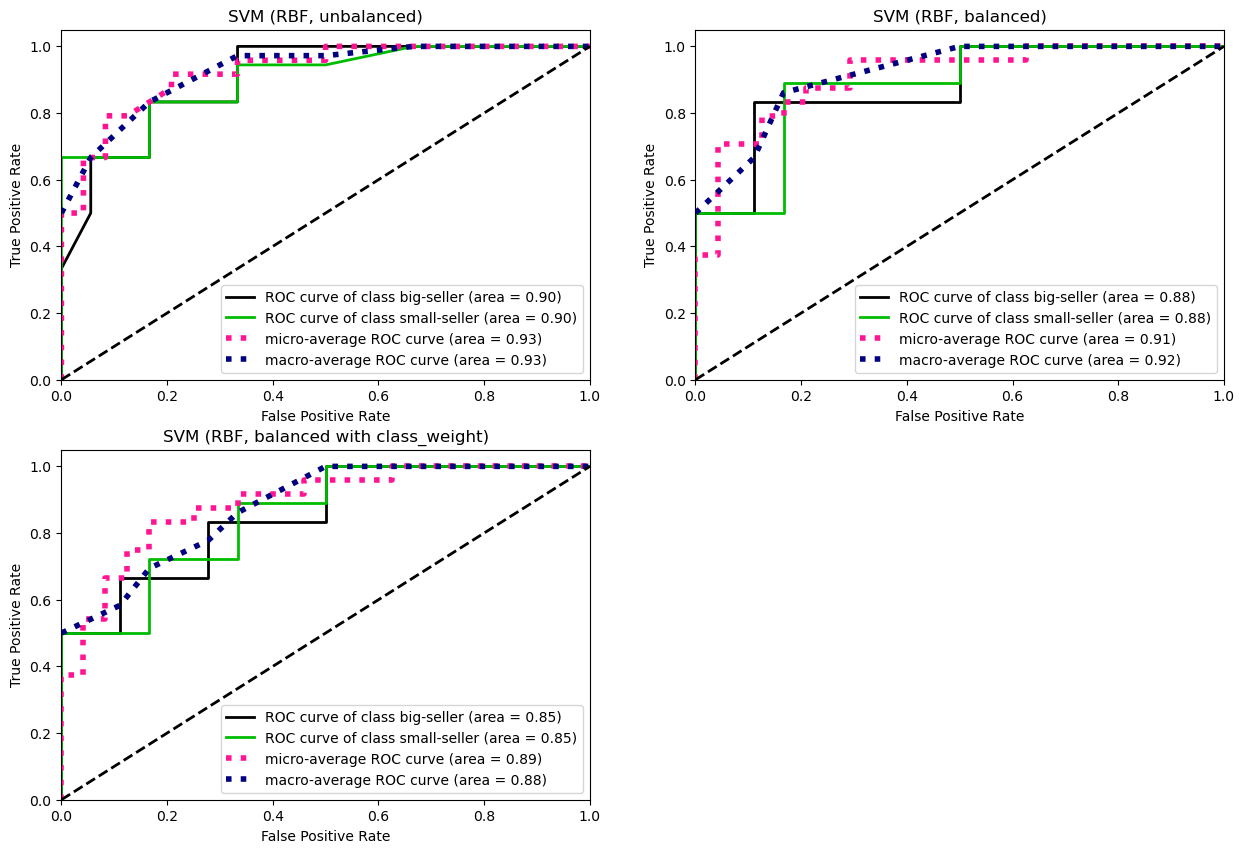

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_unb, title="SVM (RBF, unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_bal, title="SVM (RBF, balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_wei, title="SVM (RBF, balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

#### Conclusions
Here the best model is the one trained on the unbalanced dataset.  
This time there was a significant difference between the results obtained from the balanced dataset and the use of class_weight.

## Rule-based classification (Ripper)

In [83]:
#Ripper's fit method requires a single containing the labels
rip_data_unb = pd.concat([train_set, train_label], axis=1)
rip_data_bal = pd.concat([train_set_bal, train_label_bal], axis=1)

### Unbalanced

In [84]:
clf = RIPPER()

param_grid_rip = {"prune_size": np.linspace(0.1, 1, 10), 
              "k": range(2, 10)}

grid_search_rip_unb = RandomizedSearchCV(estimator=clf, 
                                     n_iter=50,
                                     param_distributions=param_grid_rip)

grid_search_rip_unb.fit(train_set, train_label, pos_class="big-seller")

print('Best parameters setting ', grid_search_rip_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rip_unb.cv_results_['mean_test_score'][0], 
      grid_search_rip_unb.cv_results_['std_test_score'][0])


#define and fit the rule-based model
ripper_unb = RIPPER(**grid_search_rip_unb.best_params_)
ripper_unb.fit(rip_data_unb, class_feat='Label', pos_class="big-seller")

test_pred_rip_unb = ripper_unb.predict(test_set, give_reasons=True)
test_pred_proba_rip_unb = ripper_unb.predict_proba(test_set)

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

Best parameters setting  {'prune_size': 0.4, 'k': 4}
Setting's accuracy score mean and std  0.7236363636363636 0.09648363026488438


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [0]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



In [85]:
print(ripper_unb.ruleset_)

[Eram=1.34-2.17]


### Balanced

In [86]:
clf = RIPPER()

param_grid_rip = {"prune_size": np.linspace(0.1, 1, 10), 
              "k": range(2, 10)}

grid_search_rip_bal = RandomizedSearchCV(estimator=clf, 
                                     n_iter=50,
                                     param_distributions=param_grid_rip)

grid_search_rip_bal.fit(train_set_bal, train_label_bal, pos_class="big-seller")

print('Best parameters setting ', grid_search_rip_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rip_bal.cv_results_['mean_test_score'][0], 
      grid_search_rip_bal.cv_results_['std_test_score'][0])


#define and fit the rule-based model
ripper_bal = RIPPER(**grid_search_rip_bal.best_params_)
ripper_bal.fit(rip_data_unb, class_feat='Label', pos_class="big-seller")

test_pred_rip_bal = ripper_bal.predict(test_set, give_reasons=True)
test_pred_proba_rip_bal = ripper_bal.predict_proba(test_set)

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

Best parameters setting  {'prune_size': 0.6, 'k': 9}
Setting's accuracy score mean and std  0.6845588235294118 0.08352630483037014


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [0]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



In [87]:
print(ripper_bal.ruleset_)

[Eram=1.34-2.17]


### Evaluation

In [88]:
#evaluation of the performance of the classifier
print('Accuracy (Unbalanced)', ripper_unb.score(test_set, test_label))
print('Precision (Unbalanced)', ripper_unb.score(test_set, test_label, precision_score))
print('Recall (Unbalanced)', ripper_unb.score(test_set, test_label, recall_score))
print("\n")
print('Accuracy (Balanced)', ripper_bal.score(test_set, test_label))
print('Precision (Balanced)', ripper_bal.score(test_set, test_label, precision_score))
print('Recall (Balanced)', ripper_bal.score(test_set, test_label, recall_score))

Accuracy (Unbalanced) 0.7916666666666666
Precision (Unbalanced) 1.0
Recall (Unbalanced) 0.16666666666666666


Accuracy (Balanced) 0.7916666666666666
Precision (Balanced) 1.0
Recall (Balanced) 0.16666666666666666


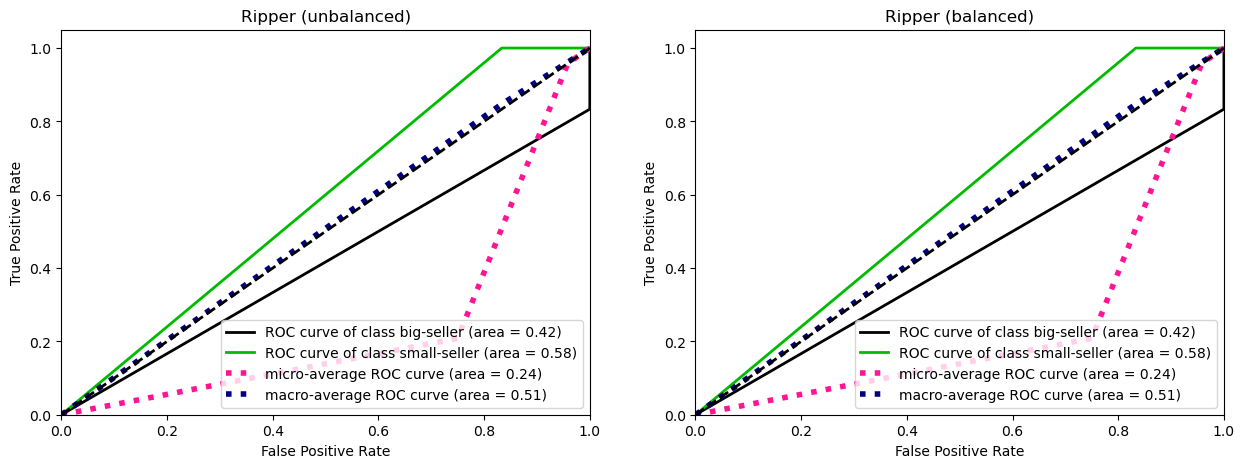

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_rip_unb, title="Ripper (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rip_bal, title="Ripper (balanced)", ax=axes[1])
plt.show()

Ripper doesn't perform too well on this dataset, probably due to the low amount of datapoints.  
In this case the balanced dataset had a negative effect.

## Multi-layer Perceptron

### Unbalanced classes

In [138]:
param_dist_mlp = {
    'solver': ["sgd", "adam"],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(x,) for x in range(10, 300, 50)],
    'max_iter': range(10, 300, 50),
    'early_stopping': [True, False]
}

clf = MLPClassifier()
grid_search_mlp_unb = GridSearchCV(clf, param_grid=param_dist_mlp,
                            n_jobs=4,
                            scoring=make_scorer(accuracy_score))

grid_search_mlp_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_mlp_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_mlp_unb.cv_results_['mean_test_score'][0], 
      grid_search_mlp_unb.cv_results_['std_test_score'][0])


mlp_unb = MLPClassifier(**grid_search_mlp_unb.best_params_).fit(train_set, train_label)

test_pred_mlp_unb = mlp_unb.predict(test_set)
test_pred_proba_mlp_unb = mlp_unb.predict_proba(test_set)

Best settings parameters  {'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 10, 'solver': 'sgd'}
Setting's accuracy score mean and std  0.5327272727272727 0.23422811513000608


/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  warnings.warn(


### Balanced classes

In [126]:
param_dist_mlp = {
    'solver': ["sgd", "adam", "lbfgs"],
    'alpha': [0.001, 0.05, 0.5],
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'max_iter': range(10, 500, 50),
    'early_stopping': [True, False]
}

clf = MLPClassifier()
grid_search_mlp_bal = GridSearchCV(clf, param_grid=param_dist_mlp,
                            n_jobs=4,
                            scoring=make_scorer(accuracy_score))

grid_search_mlp_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_mlp_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_mlp_bal.cv_results_['mean_test_score'][0], 
      grid_search_mlp_bal.cv_results_['std_test_score'][0])


mlp_bal = MLPClassifier(**grid_search_mlp_bal.best_params_).fit(train_set_bal, train_label_bal)

test_pred_mlp_bal = mlp_bal.predict(test_set)
test_pred_proba_mlp_bal = mlp_bal.predict_proba(test_set)

Best settings parameters  {'alpha': 0.001, 'early_stopping': True, 'learning_rate': 'constant', 'max_iter': 10, 'solver': 'sgd'}
Setting's accuracy score mean and std  0.5 0.055804899885324354


### Evaluation

In [127]:
print("MLP (unbalanced)")
report_scores(test_label, test_pred_mlp_unb)
print("\n")
print("MLP (balanced)")
report_scores(test_label, test_pred_mlp_bal)

MLP (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.80      0.67      0.73         6
small-seller       0.89      0.94      0.92        18

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24



MLP (balanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



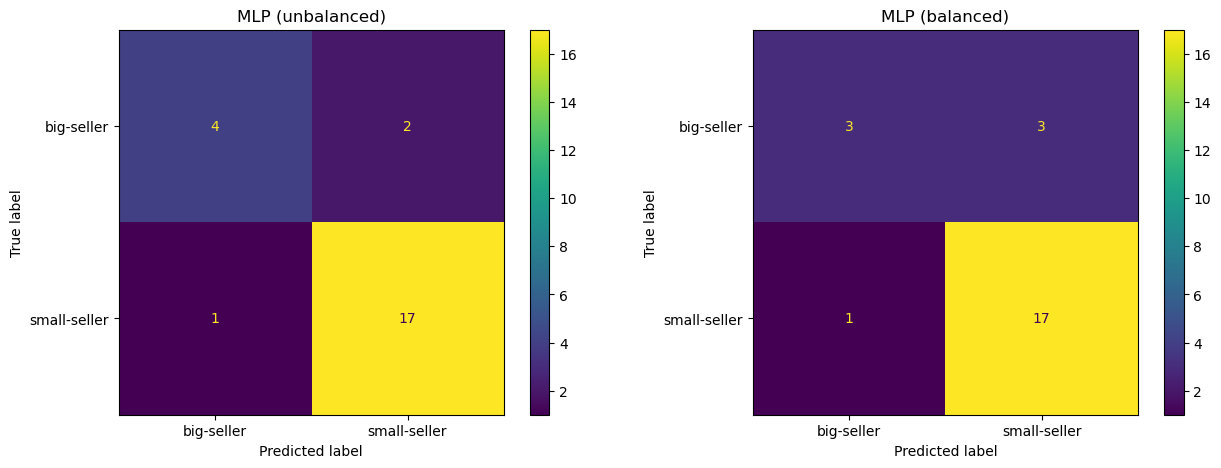

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("MLP (unbalanced)")
plot_confusion_matrix(mlp_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("MLP (balanced)")
plot_confusion_matrix(mlp_bal, test_set, test_label, ax=axes[1])
plt.show() 

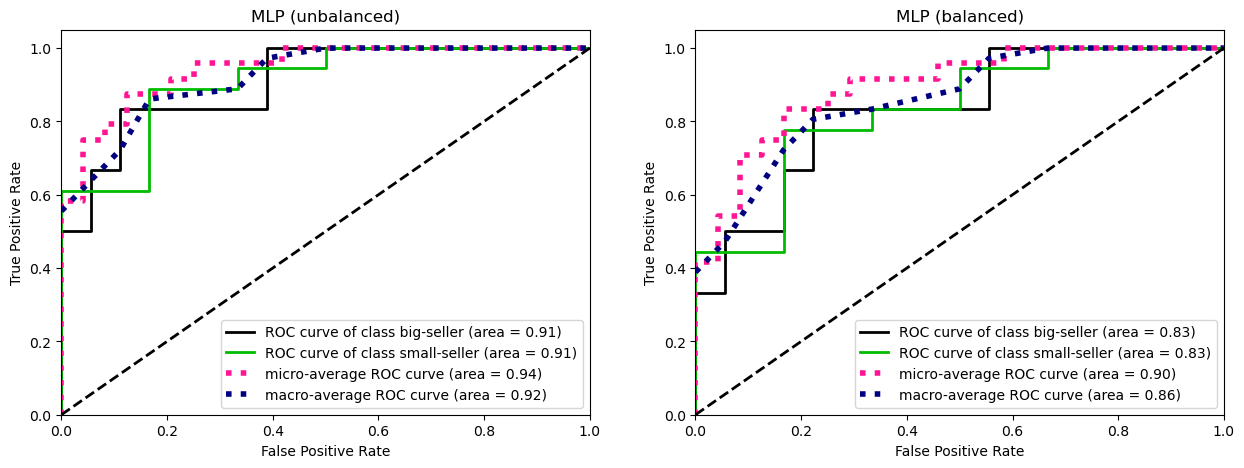

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_mlp_unb, title="MLP (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_mlp_bal, title="MLP (balanced)", ax=axes[1])
plt.show()

## TODO
- Check for overfitting
- decision boundary plot  
- fix warnings
- write conclusions
- check SMOTE algorithm